# Scientific Python Final Project
## Analyzing painter networks with Python

Central European University, Vienna, Austria

Instructor: Márton Pósfai, TA: Kassandra Friebe

Student: Mihaly Hanics

<u> **Description:**</u> This work is part of a bigger project (carried out with students Nurbek Bektursyn and Asset Kabdula) observing the properties and structures of painter, style and movement networks. The project includes gathering, preprocessing the data, possibly the hardest task (and not perfected, further work is to exclude less painters while combining datasets), creating various types of networks from certain attributes of the data (both static and dynamic), and analyzing the networks. We have information on ~2500 painters from the 13th century to the 20th, where they were born, where and when they painted, how many artworks they painted per style, what movement they belonged to, a list of some of the painters who influenced them, who they influenced, the school they studied at and friends and coworkers (not all information is available for all painters, but most information is available for most painters). In this particular work, I wanted to gain more information about the structural properties and statistics of art style, movement, and painter networks. <br>
For this, I created three types of networks to analyze:

-*style networks* (one basic weighted network, where two styles are connected if a painter painted in both styles, this amount would be the "common number" of two styles for a painter, edge weights equaling the sum of common numbers over all painters for these two styles, and also one thresholded network at edge weight >= 100)<br>
-*movement networks*: two movements have a link if there are two paintings with the same style, but from different movements (same exact idea as previously, threshold at 100)<br>
-*painter networks*: InfluencedOn network from the InfluencedOn data (“pre-defined”, an edge between two artists is created if in the Art500k dataset there was any info on one artist inspiring another on a painting), and a time-and-place network (which is dynamic in a sense) where two painters share a connection roughly if they were at the same place(s) around the same time(s). The reason why these two attributes were considered, and style not, is because these three are the major factors in what connections (network) an artist has, but if we were to analyze stylistic connections then the network would be biased (higher percentage of links between same style/movement painters).


<u> **Important:**</u> We have not included the data preprocessing here, just the creation of networks, as this file is only meant to contain analysis. Getting and preparing data was also a complex and lengthy task, as there was no extensive painter dataset available we had to create our own data from paintings datasets, such as WikiArt, Art500k, and some Wikipedia fetching+manual corrections. The data gathering and preprocessing can be found on GitHub under [me9hanics/PainterPalette](https://github.com/me9hanics/PainterPalette). All analysis including this and others can be found on GitHub under [me9hanics/ArtProject](https://github.com/me9hanics/ArtProject/), this includes analysis that was done with GePhi (and Excel).

<u> **Note:**</u> The difference between "style" and "movement" is that style is an attribute of a painting, while movement is an attribute of a painter (well, that's one way to look at it, and in our dataset, each painter is only connected to one movement). A painter can paint in multiple styles, but belongs to only one movement, here we store the styles a painter painted in with the number of paintings he painted in that style.

I used Pandas+Numpy for storing and manipulating the data, NetworkX for creating and analyzing the networks, Matplotlib+Seaborn for plots. I also tried using igraph and graph-tool, but for Windows reasons I found NetworkX to be the most convenient.

The 5 highlighted figures:



## 0. Imports, initial procedures
(note: for the style and movement networks, I used only the WikiArt dataset, grouping by artists and styles)

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

url = "https://raw.githubusercontent.com/me9hanics/PainterPalette/main/datasets/artists.csv"
artists = pd.read_csv(url)
wikiart_artists_styles = pd.read_csv('https://raw.githubusercontent.com/me9hanics/PainterPalette/main/datasets/wikiart_artists_styles_grouped.csv')
artists

,artist,Nationality,birth_place,birth_year,styles,styles_extended,StylesYears,StylesCount,movement,ArtMovement,...,LastYear,Places,PlacesYears,PlacesCount,PaintingSchool,Influencedby,Influencedon,Pupils,Teachers,FriendsandCoworkers
0,Ad Reinhardt,American,Buffalo,1913.0,"Abstract Art, Abstract Expressionism, Color Fi...","{Abstract Art:15},{Abstract Expressionism:5},{...","Expressionism:1944-1946,,Abstract Art:1937-194...","{Expressionism:7}, {Abstract Art:15}, {Color F...",Abstract Expressionism,"{Abstract Expressionism,Minimalism:52},",...,1966.0,"US, NY, Canberra, Fort Worth, Buffalo, Austral...","New York City:1938-1966,,NY:1938-1966,,US:1938...","{New York City:29},{NY:31},{US:32},{Buffalo:2}...","New York School,American Abstract Artists,Iras...","Piet Mondrian,Kazimir Malevich,Josef Albers,","Donald Judd,Barnett Newman,Mark Rothko,Frank S...",NaN,NaN,"Jackson Pollock,"
1,Adnan Coker,Turkish,NaN,NaN,"Abstract Art, Abstract Expressionism","{Abstract Art:25},{Abstract Expressionism:3}","Abstract Art:1992-2008,,Abstract Expressionism...","{Abstract Art:25}, {Abstract Expressionism:3}",Abstract Art,"{Abstract Art:28},",...,2008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Akkitham Narayanan,Indian,Kerala,1939.0,Abstract Art,{Abstract Art:17},"Abstract Art:1974-1974,",{Abstract Art:17},Abstract Art,"{Abstract Art:17},",...,1974.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alberto Magnelli,"Italian,French",Florence,1888.0,"Abstract Art, Art Nouveau (Modern), Cubism, Ex...","{Abstract Art:19},{Art Nouveau (Modern):2},{Cu...","Abstract Art:1916-1971,,Cubism:1914-1935,,Meta...","{Abstract Art:21}, {Cubism:10}, {Metaphysical ...",Abstract Art,"{Abstract Art,Cubo-Futurism,Concrete Art (Conc...",...,1971.0,NaN,NaN,NaN,Abstraction-Création,NaN,NaN,NaN,NaN,NaN
4,Alekos Kontopoulos,Greek,Lamia,1904.0,"Abstract Art, Cubism, Expressionism, Post-Impr...","{Abstract Art:26},{Cubism:5},{Expressionism:10...","Post-Impressionism:1932-1955,,Expressionism:19...","{Post-Impressionism:8}, {Expressionism:11}, {R...",Social Realism,"{Abstract Art,Social Realism:79},",...,1974.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,Marianne von Werefkin,NaN,Tula,1860.0,Unknown,{Unknown:61},NaN,NaN,Expressionism,"{Der Blaue Reiter:1},",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2453,Robert Demachy,French,Saint-Germain-en-Laye,1859.0,Unknown,{Unknown:24},NaN,NaN,Pictorialism,"{Pictorialism:24},",...,1914.0,France,NaN,{France:2},NaN,NaN,NaN,NaN,NaN,NaN
2454,Wolfgang Tillmans,NaN,Remscheid,1968.0,Unknown,{Unknown:9},NaN,NaN,Contemporary,NaN,...,2001.0,"London, United Kingdom",NaN,"{London:1},{United Kingdom:1}",NaN,NaN,NaN,NaN,NaN,NaN
2455,Wu Daozi,Chinese,Chang'an,680.0,Unknown,{Unknown:8},NaN,NaN,Tang Dynasty (618–907),"{Tang Dynasty (618–907):8},",...,NaN,NaN,NaN,NaN,Four fathers of Chinese painting,NaN,NaN,NaN,NaN,NaN


Let's see an example, Picasso:

In [15]:
(artists[artists['artist'] == 'Pablo Picasso'].squeeze())


artist                                                     Pablo Picasso
Nationality                                                      Spanish
birth_place                                                       Málaga
birth_year                                                        1881.0
styles                 Academicism, Analytical Cubism, Art Nouveau (M...
styles_extended        {Academicism:1},{Analytical Cubism:48},{Art No...
StylesYears            Impressionism:1895-1916,,Expressionism:1899-19...
StylesCount            {Impressionism:22}, {Expressionism:220}, {Symb...
movement                                              Post-Impressionism
ArtMovement                 {Modern art:1},{Surrealism:1},{Cubism:1132},
pictures_count                                                      1170
FirstYear                                                         1899.0
LastYear                                                          1972.0
Places                 London, Manchester, Greece, 

The mentioned attributes are all present. As we see, in some columns the string formatting/styling in the cells is a bit unnatural, such as `{Paris:69}`. These are mostly designed such that parsing would be easy, and that they can give some intuition of the data inside the cell. For example, you could think of the `PlacesCount` column as a series of dictionaries, where the keys are the places and the values are the number of artworks the painter painted there. One thing to note is that here, for example, `Teachers` displays not the teachers but some periods of his work, but this attribute is not used in this work.<br>
(In the future I hope to create a *JSON* format of the dataset too, as the hierarchical structure of the data would be better represented this way. Think of this: a level in this structure could be art movement, inside it, are artists with some base data like birthplace, year of birth and death and other geographical data, inside it are paintings with all contained data (even better would be including eras of painters in their substructure, and inside them the paintings)...)

We see that years in birth/first/last year are floats instead of ints, this is because of `NaN` values and sadly cannot be changed. I tried to name columns in a way that they are self-explanatory, but it needs to be said that the difference between `movement` and `ArtMovement` (unused) is the first is from WikiArt data, the latter is Art500k, and `First/LastYear` means the earliest dated painting's year in the Art500k dataset.<br>
Let's do some basic showcasing of playing with the data:

In [53]:
painter = "Pablo Picasso"
#Get tuples as strings, by splitting on commas
Picasso_styles_years = [x for x in artists[artists['artist'] == painter]["StylesYears"].iloc[0].split(",") if x != '']
#Split style and years
Picasso_styles_years_tuple = [(x.split(":")[0], int(x.split(":")[1].split("-")[0]), int(x.split(":")[1].split("-")[1])) for x in Picasso_styles_years]
Picasso_styles_years_tuple

[('Impressionism', 1895, 1916),
 ('Expressionism', 1899, 1972),
 ('Symbolism', 1900, 1958),
 ('Cubism', 1906, 1971),
 ('Post-Impressionism', 1890, 1938),
 ('Naïve Art (Primitivism)', 1902, 1970),
 ('Analytical Cubism', 1907, 1913),
 ('Neoclassicism', 1906, 1970),
 ('Synthetic Cubism', 1912, 1926),
 ('Realism', 1893, 1918),
 ('Pointillism', 1917, 1917),
 ('Surrealism', 1920, 1971),
 ('Art Nouveau (Modern)', 1897, 1920),
 ('Academicism', 1924, 1924),
 ('Japonism', 1901, 1902)]

Now let's create the networks:<br>


### Style and movement networks:

In [46]:
wikiart_styles = wikiart_artists_styles['style'].unique(); wikiart_artists = wikiart_artists_styles['artist'].unique(); wikiart_movements = wikiart_artists_styles['movement'].unique()

G_styles = nx.Graph(); G_styles.add_nodes_from(wikiart_styles)
G_movements = nx.Graph(); G_movements.add_nodes_from(wikiart_movements)
G_artists = nx.Graph(); G_artists.add_nodes_from(wikiart_artists) #Not the final graph as there are more artist graphs, but this is the base

#This algorithm is not totally efficient, but we are not dealing with a large dataset so
for i in range(len(wikiart_artists)): #Through all artists
    #First get all styles of the artist
    artist_styles = (wikiart_artists_styles[wikiart_artists_styles['artist'] == wikiart_artists[i]][['style', 'count']]).reset_index(drop=True)
    #Iterate through all styles of the artist
    for j in range(len(artist_styles)):
        for k in range(j+1, len(artist_styles)):
            #Create an edge between two styles
            if not G_styles.has_edge(artist_styles['style'].iloc[j], artist_styles['style'].iloc[k]):
                    G_styles.add_edge(artist_styles['style'].iloc[j], artist_styles['style'].iloc[k], weight= min(artist_styles['count'].iloc[j], artist_styles['count'].iloc[k]))
            else:
                G_styles[artist_styles['style'].iloc[j]][artist_styles['style'].iloc[k]]['weight'] += min(artist_styles['count'].iloc[j], artist_styles['count'].iloc[k])

#Drop style "Unknown"
G_styles.remove_node('Unknown')

#Threshold graph: remove edges with weight less than 100
threshold = 100
G_styles_threshold_100 = G_styles.copy()
for edge in G_styles_threshold_100.edges():
    if G_styles_threshold_100[edge[0]][edge[1]]['weight'] < threshold:
        G_styles_threshold_100.remove_edge(edge[0], edge[1])

for i in range(len(wikiart_styles)):
    styles_movements = (wikiart_artists_styles[wikiart_artists_styles['style'] == wikiart_styles[i]][['movement', 'count']]).reset_index(drop=True)
    for j in range(len(styles_movements)):
        for k in range(j+1, len(styles_movements)):
            if not G_movements.has_edge(styles_movements['movement'].iloc[j], styles_movements['movement'].iloc[k]):
                if not styles_movements['movement'].iloc[j] == styles_movements['movement'].iloc[k]:
                    G_movements.add_edge(styles_movements['movement'].iloc[j], styles_movements['movement'].iloc[k], weight= min(styles_movements['count'].iloc[j], styles_movements['count'].iloc[k]))
            else:

                G_movements[styles_movements['movement'].iloc[j]][styles_movements['movement'].iloc[k]]['weight'] += min(styles_movements['count'].iloc[j], styles_movements['count'].iloc[k])
G_movements

#Threshold graph: remove edges with weight less than 100
#threshold = 100
G_movements_threshold_100 = G_movements.copy()
for edge in G_movements_threshold_100.edges():
    if G_movements_threshold_100[edge[0]][edge[1]]['weight'] < threshold:
        G_movements_threshold_100.remove_edge(edge[0], edge[1])

Since a style network is built on top of painters, and a movement network is built on top of styles, we can just plot them as a multi-layer graph. <br>
<details><summary><u>Code and viz</u></summary>

```python
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d.art3d import Line3DCollection
%matplotlib inline

pos1 = nx.spring_layout(G_artists, k=0.9, iterations=2)
pos2 = nx.spring_layout(G_styles, k=2.4,iterations=70)
pos3 = nx.spring_layout(G_movements_threshold_100, k=5.4,iterations=7) #G_movements_A is too dense

#Setup for the figure
cols = ['mediumseagreen', 'darksalmon','steelblue' ]#Colors
np.random.seed(42)
graphs = [G_artists,G_styles, G_movements_threshold_100]
w = 8; h = 6
fig, ax = plt.subplots(1, 1, figsize=(w,h), dpi=200, subplot_kw={'projection':'3d'})

for gi, G in enumerate(graphs):
    # node positions
    if gi == 0:
        pos = pos1
    if gi == 1:
        pos = pos2
    if gi == 2:
        pos = pos3
    
    xs = list(list(zip(*list(pos.values())))[0])
    ys = list(list(zip(*list(pos.values())))[1])
    zs = [gi]*len(xs) # set a common z-position of the nodes 
    
    # add within-layer edges (One could add between-layer edges here as well, see GitHub: jkbren/matplotlib_multilayer_network)
    lines3d = [(list(pos[i])+[gi],list(pos[j])+[gi]) for i,j in G.edges()]
    line_collection = Line3DCollection(lines3d, color="grey", zorder=gi, alpha=0.2)
    ax.add_collection3d(line_collection)

    # nodes
    cs = [cols[gi]]*len(xs) #Color
    ax.scatter(xs, ys, zs, c=cs, edgecolors='.2',  alpha=0.5, zorder=gi+1) #Add nodes
    
    # add a plane to designate the layer
    xdiff = max(xs)-min(xs)
    ydiff = max(ys)-min(ys)
    ymin = min(ys)-ydiff*0.1
    ymax = max(ys)+ydiff*0.1
    xmin = min(xs)-xdiff*0.1 * (w/h)
    xmax = max(xs)+xdiff*0.1 * (w/h)
    xx, yy = np.meshgrid([xmin, xmax],[ymin, ymax])
    zz = np.zeros(xx.shape)+gi
    ax.plot_surface(xx, yy, zz, color=cols[gi], alpha=0.1, zorder=gi)

    # add label
    if gi == 0:
        text = "Painters"
    if gi == 1:
        text = "Styles"
    if gi == 2:
        text = "Movements"
    layertext = ax.text(0.0, 0.85, gi*0.95+0.5, text,
                        color='.95', fontsize='large', zorder=1e5, ha='left', va='center',
                        path_effects=[path_effects.Stroke(linewidth=3, foreground=cols[gi]),
                                      path_effects.Normal()])

# set them all at the same x,y,zlims
ax.set_ylim(min(ys)-ydiff*0.1,max(ys)+ydiff*0.1)
ax.set_xlim(min(xs)-xdiff*0.1,max(xs)+xdiff*0.1)
ax.set_zlim(-0.1, len(graphs) - 1 + 0.1)

# select viewing angle
angle = 30
height_angle = 20
ax.view_init(height_angle, angle)

# how much do you want to zoom into the fig
ax.dist = 9.5

ax.set_axis_off()

# plt.savefig('multilayer_network.png',dpi=425,bbox_inches='tight')
plt.show()


```

![image.png](attachment:image.png)

</details>

To show the difference between thresholding and not, see the centralities for movements: 

Unthresholded:

In [44]:
degree_centrality_styles = nx.degree_centrality(G_movements)
closeness_centrality_styles = nx.closeness_centrality(G_movements)
betweenness_centrality_styles = nx.betweenness_centrality(G_movements)
eigenvector_centrality_styles = nx.eigenvector_centrality(G_movements, max_iter=1000)

centralities_styles_df = pd.DataFrame({
    'Degree Centrality': degree_centrality_styles,
    'Closeness Centrality': closeness_centrality_styles,
    'Betweenness Centrality': betweenness_centrality_styles,
    'Eigenvector Centrality': eigenvector_centrality_styles
})
centralities_styles_df.head(5)

,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality
Abstract Expressionism,0.918033,0.920412,0.029680,0.107795
Abstract Art,0.877049,0.884738,0.008157,0.107200
Social Realism,0.852459,0.864630,0.006798,0.106051
Kinetic art,0.844262,0.858129,0.002060,0.105759
Avant-garde,0.811475,0.833074,0.001162,0.103726


In [50]:
print('Top 7 highest betweenness centrality styles in threshold network:')
centralities_styles_df['Degree Centrality'].sort_values(ascending=False).head(7)

Top 7 highest betweenness centrality styles in threshold network:


Abstract Expressionism    0.918033
New Ink Art               0.918033
Expressionism             0.901639
Contemporary              0.885246
Pop Art                   0.885246
Impressionism             0.885246
Symbolism                 0.885246
Name: Degree Centrality, dtype: float64

I showcased the degree centrality which is already quite "surrealistic". It would not be logical to put styles such as new ink art so high up, and in all centrality measures contemporary movements seems more central than an art enthusiast would suggest.

Thresholded:

In [51]:
degree_centrality_styles_2 = nx.degree_centrality(G_movements_threshold_100)
closeness_centrality_styles_2 = nx.closeness_centrality(G_movements_threshold_100)
betweenness_centrality_styles_2 = nx.betweenness_centrality(G_movements_threshold_100)
eigenvector_centrality_styles_2 = nx.eigenvector_centrality(G_movements_threshold_100, max_iter=1000)

centralities_styles_df_2 = pd.DataFrame({
    'Degree Centrality': degree_centrality_styles_2,
    'Closeness Centrality': closeness_centrality_styles_2,
    'Betweenness Centrality': betweenness_centrality_styles_2,
    'Eigenvector Centrality': eigenvector_centrality_styles_2
})
print('The 7 highest betweenness centrality styles in threshold network:')
centralities_styles_df_2['Degree Centrality'].sort_values(ascending=False).head(7)

The 7 highest betweenness centrality styles in threshold network:


Abstract Art     0.729508
Expressionism    0.721311
Contemporary     0.688525
Surrealism       0.680328
Realism          0.631148
Romanticism      0.614754
Impressionism    0.614754
Name: Degree Centrality, dtype: float64

That's much better. If we were to account for weights for centralities (only implemented for eigenvalue centrality, but one may use the negative values or reciprocals of the edge weights for distance in betweenness centrality), then the results would be even more well-received. 

In [52]:
G = G_movements_threshold_100.copy()
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = -G[edge[0]][edge[1]]['weight']
betweenness_centrality_styles_2_2 = nx.betweenness_centrality(G, weight='weight')
centralities_styles_2_df_3 = pd.DataFrame({
    'Betweenness Centrality': betweenness_centrality_styles_2_2
})
del G #Only needed it here 
centralities_styles_2_df_3['Betweenness Centrality'].sort_values(ascending=False).head(10)

Expressionism         0.717518
Impressionism         0.716434
Post-Impressionism    0.715486
Realism               0.712912
Romanticism           0.697331
Rococo                0.670844
Abstract Art          0.670709
Neoclassicism         0.668270
Baroque               0.663325
Surrealism            0.645238
Name: Betweenness Centrality, dtype: float64

For betweenness centrality, these results seem to make sense. 19th century styles seem to be the "division line" between all (older and newer) styles, plus these styles have strong connections between them, influencing each other's strenght. In general, realism and impressionism are considered to be the most influential styles, which is better represented here (both are at the top with value around 0.71).

### InfluencedOn painters network:
(directed, to see who influenced who)<br>
(note: not a fast algorithm, would have been better to just gather once the InfluencedOn data then try-catch choosing nodes from the names listed to add an edge, but this was fine too)

In [54]:
G_influencedon = nx.DiGraph(); G_influencedon.add_nodes_from(artists['artist'])

for i in range(len(artists)):
    influencedon1 = [x for x in str(artists[artists['artist'] == artists['artist'][i]]['Influencedon'].iloc[0]).split(",") if x != '']

    for j in range(i+1, len(artists)):
        influencedon2 = [x for x in str(artists[artists['artist'] == artists['artist'][j]]['Influencedon'].iloc[0]).split(",") if x != '']

        if (artists['artist'].iloc[j] in influencedon1) or (artists['artist'].iloc[i] in influencedon2):
            G_influencedon.add_edge(artists['artist'].iloc[i], artists['artist'].iloc[j])

#Remove isolated nodes
G_influencedon.remove_nodes_from(list(nx.isolates(G_influencedon)))

### Lastly, the time-and-place painters network:
This one is a bit more complicated. I created a time "index" (measure of similarity) and a place index for each painter pair, and if these values and their product are higher than given thresholds, then a link is created between to painters.

The main attributes:

- place of birth
- places
- places by years
- nationality
- years of birth, first and last painting's year in the dataset

**Settings:**

In [73]:
birthplace_weight = 0.5; places_weight = 0.4; nationality_weight = 0.8
weights = [birthplace_weight,places_weight,nationality_weight]

year_index_threshold = 0
places_threshold = 1.5
time_place_threshold = 0.4

**Year index between two artists:**

Measure of how close two artists were in time. The closer they were, the higher the value. The value is calculated as follows:<br>
Firstly, count the number of years the two artists were alive at the same time (called count). For either artist, if a year is between his birthyear and first year of painting appearing in the dataset, instead of adding 1 year to the count, we add 0.1 (and in the case when this is true for both artists, add 0.01 instead).<br>
In the end, we divide the count by the lifespan of the artist who lived less. This is because if we just took the average of the two  painters' lifespan, painters who lived for a longer time would have too many high indices. Sure, we can say that a painter who lived longer likely met more painters, but just this is not the point, the point is rather that if you take a painter who lived for a short time and a painter who lived for a long time, the longer living painter's lengthy lifetime typically shouldn't be a factor of the probability of the shorter living painter meeting him. Painter X who died at age 30 and had a 10-year span to meet other painters is equally likely to have met Painter Y who lived for 10 years more after Painter X's death, as Painter Z who lived for 30 more years after Painter X died. The increase of amount of painters met should only come from having longer overlapping periods with more artists (from living longer). On the other hand, lifespan should somehow be also accounted, because if not (if we just divide by a number like 100, or don't divide at all), short living painters (like the short-lived Viennese Egon Schiele, who is a very influential painter despite having lived only 28 years) would have likely no connections in the graph, which is why their age should be accounted for somehow. This is why we divide by the shorter living painter's lifespan, which is still enough to have that longer living painters have more connections.<br>

In [74]:
def year_index(years1, years2):
    #Year_index: years between first and last year are accounted with weight 1, years between birth and first year are accounted with weight 0.1.
    #For each overlapping year, we add 1 times the weights. Lastly, we divide by the total number of years of the younger artist.
    year_index = 0
    if(years1[0] > years2[0]):
        yearst = years1;years1 = years2;years2 = yearst
    #No overlap
    if(years1[2] < years2[0]):  #Not needed, but better for computation
        return 0
    for year in range((years1)[0], np.min([years1[2],years2[2]])+1):
        c = 1
        if year < years2[0]:
            c = 0
            continue
        if(year<years1[1]):
            c = c*0.2
        if(year<years2[1]):
            c = c*0.2
        year_index += c
    year_index = year_index/(np.min([years1[2]-years1[0],years2[2]-years2[0]])+1)
    return year_index

Matisse_years1=[1869, 1890, 1954]
Picasso_years2=[1881, 1900, 1973]
print(round(year_index(Matisse_years1, Picasso_years2), 3))

0.667


**Place index between two artists:**

Measure for how close are two artists to each other in terms of places they lived/painted in and nationality. Originally, birthplace was also a factor, but it uses GeoPy's Nominatim, and running it on the full data tends to make it time out. <br>

<details> <summary><u>Function for birthplaces</u></summary>

```python

from geopy.geocoders import Nominatim    
geolocator = Nominatim(user_agent="PainterProject")

# Function to get the country from a birthplace
def get_country(birthplace):
    location = geolocator.geocode(birthplace)
    if location:
        return location.address.split(",")[-1].strip()
    return None

```

</details>

In [75]:
def place_index(placescount1, placescount2, birthplace1, birthplace2, nationality1, nationality2):
    #Places index
    i1 = 0; i2 = 0
    if placescount1 is not np.nan and placescount2 is not np.nan:
        places1_count_tuple = [(x.split(":")[0], int(x.split(":")[1])) if ":" in x else (x, 0) for x in placescount1]
        places2_count_tuple = [(x.split(":")[0], int(x.split(":")[1])) if ":" in x else (x, 0) for x in placescount2]
        for tuple1 in places1_count_tuple:
            for tuple2 in places2_count_tuple:
                if(tuple1[0] == tuple2[0]):
                    i1 += tuple1[1]; i2 += tuple2[1]
        sum1 = np.sum([x[1] for x in places1_count_tuple]); sum2 = np.sum([x[1] for x in places2_count_tuple])
        i1 = i1/np.min([sum1,25]); i2 = i2/np.min([sum2,25]) #This allows the places to go over 1, as many paintings in one place suggests a strong connection
        i = np.max([i1,i2])
    else:
        i = 0
    n1 = 0; n2 = 0
    if type(nationality1) == float or type(nationality2) == float:
        n = 0 #One of them is a nan
    else:
        for nat1 in nationality1.split(','):
            for nat2 in nationality2.split(','):
                if(nat1 == nat2):
                    n1 += 1; n2 += 1
        n = n1*n2/len(nationality1.split(','))/len(nationality2.split(','))
    b = 1 if birthplace1 == birthplace2 else 0
        
    """
        #Note: this codes almost always times out.
        else:
        #If they are in the same country, we give a weight of 0.5
        try:
            b = 0.5 if get_country(birthplace1) == get_country(birthplace2) else 0
        except:
            b = 0; print("Error with birthplaces: ", birthplace1, birthplace2)
    """

    return weights[0]*b + weights[1]*i + weights[2]*n


Michelangelo_places_count = [x.replace("{","").replace("}","") for x in artists[artists['artist'] == "Michelangelo"]["PlacesCount"].iloc[0].split(",") if x != '']
Picasso_places_count = [x.replace("{","").replace("}","") for x in artists[artists['artist'] == "Pablo Picasso"]["PlacesCount"].iloc[0].split(",")]
round(place_index(Michelangelo_places_count, Picasso_places_count, "Caprese", "Malaga", artists[artists['artist'] == "Michelangelo"]["Nationality"].iloc[0], artists[artists['artist'] == "Michelangelo"]["Nationality"].iloc[0]),3)

5.856

Finally create the time and place network:

In [76]:
G_time_and_place = nx.Graph(); G_time_and_place.add_nodes_from(artists['artist'])

for i in range(len(artists['artist'])):
    artist1 = artists['artist'].iloc[i]
    geo_style_data1 = artists[artists['artist']==artist1].reset_index().loc[0][['birth_place','Nationality','Places', 'PlacesYears','PlacesCount','PaintingSchool','birth_year', 'FirstYear','LastYear', 'StylesCount']]
    years1 = [geo_style_data1['birth_year'], geo_style_data1['FirstYear'], geo_style_data1['LastYear']]
    if (np.isnan(years1[0])) or (np.isnan(years1[1])) or (np.isnan(years1[2])):
        continue
    for j in range(i+1, len(artists['artist'])):
        artist2 = artists['artist'].iloc[j]
        geo_style_data2 = artists[artists['artist']==artist2].reset_index().loc[0][['birth_place','Nationality','Places', 'PlacesYears','PlacesCount','PaintingSchool','birth_year', 'FirstYear','LastYear','StylesCount']]
        years2 = [geo_style_data2['birth_year'], geo_style_data2['FirstYear'], geo_style_data2['LastYear']]
        if (np.isnan(years2[0])) or (np.isnan(years2[1])) or (np.isnan(years2[2])):
            continue
        #Year index
        year_index_val = year_index([int(year) for year in years1], [int(year) for year in years2])
        #Place index
        places1 = geo_style_data1["PlacesCount"]; places2 = geo_style_data2["PlacesCount"]
        if((places1 is not np.nan) & (places2 is not np.nan)):
            places1m = [x.replace("{","").replace("}","") for x in places1.split(",") if x != '']
            places2m = [x.replace("{","").replace("}","") for x in places2.split(",") if x != '']
        else:
            places1m = np.nan; places2m = np.nan
        birthplace1 = geo_style_data1["birth_place"]; birthplace2 = geo_style_data2["birth_place"]
        nationality1= geo_style_data1['Nationality']; nationality2 = geo_style_data2['Nationality']
        place_index_val = place_index(places1m, places2m, birthplace1, birthplace2, nationality1, nationality2)
        if (year_index_val > year_index_threshold) and (place_index_val > places_threshold) and (place_index_val*year_index_val > time_place_threshold):
            G_time_and_place.add_edge(artist1, artist2, weight=year_index_val*place_index_val)
            nx.set_edge_attributes(G_time_and_place, {(artist1, artist2): year_index_val}, 'year_index')
            nx.set_edge_attributes(G_time_and_place, {(artist1, artist2): place_index_val}, 'place_index')

G_time_and_place.remove_nodes_from(list(nx.isolates(G_time_and_place)))

I found afterwards, that a threshold of time_and_place_index => 1 seems more fitting, in this case, we can easily threshold to higher values:

In [79]:
def create_subgraph(graph_with_edgeweights,edge_threshold):
    G = nx.Graph()
    for edge in graph_with_edgeweights.edges():
        if graph_with_edgeweights[edge[0]][edge[1]]['weight'] > edge_threshold:
            G.add_edge(edge[0],edge[1])
    return G

G_time_and_place = create_subgraph(G_time_and_place, 1)

### The resulting networks:

Some plot functions:

In [96]:
def plot_network(G, pos, node_size=60, node_color='lightblue', edge_color='gray', width=1, edge_alpha=0.5, labels=False, label_font_size=10):
    plt.figure(figsize=(10,10))
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
    nx.draw_networkx_edges(G, pos, width=width,alpha=edge_alpha, edge_color=edge_color)
    if labels:
        nx.draw_networkx_labels(G, pos, font_size=label_font_size, font_family='sans-serif')
    plt.axis('off')
    plt.show()

def plot_4_networks_2d_subplots(graphs, titles, layout_params_list=None):
    fig, axes = plt.subplots(2, 2, figsize=(10,10))
    axes = axes.flatten()

    for gi, G in enumerate(graphs):
        layout_params = layout_params_list[gi] if layout_params_list else None
        pos = nx.spring_layout(G, **layout_params) if layout_params else nx.spring_layout(G)

        nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5, edge_color='grey', ax=axes[gi])
        nx.draw_networkx_nodes(G, pos, node_size=60, node_color='green', alpha=0.5, ax=axes[gi])

        axes[gi].set_title(titles[gi])
        axes[gi].set_axis_off()
    plt.show()


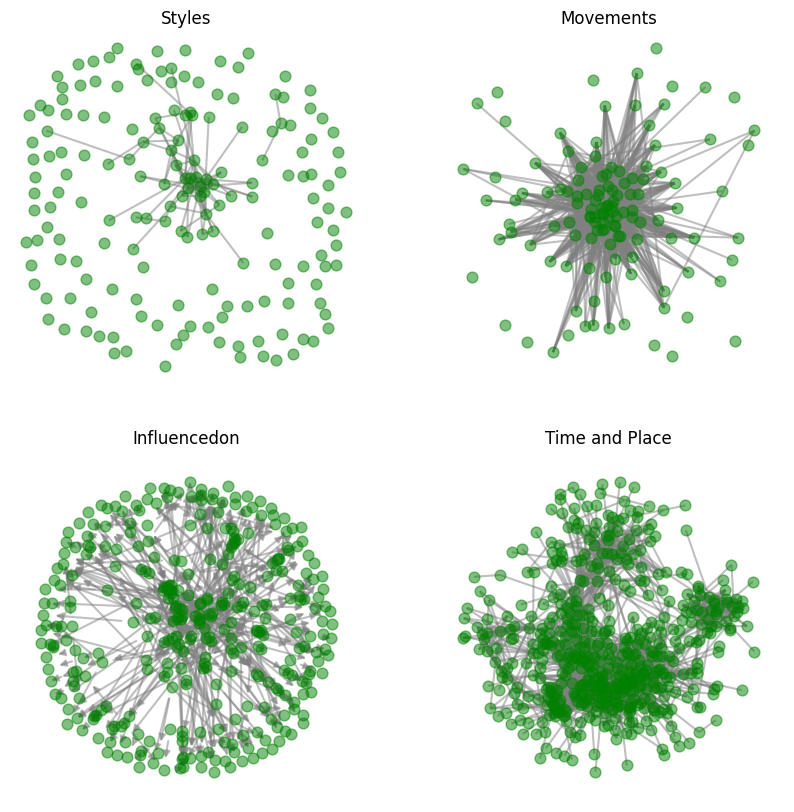

In [99]:
graphs = [G_styles_threshold_100, G_movements_threshold_100, G_influencedon, G_time_and_place ]
titles = ["Styles", "Movements", "Influencedon", "Time and Place"]
layout_params=[{'k': 0.7, 'iterations': 10}, {'k': 2.1, 'iterations': 8}, {'k':None, 'iterations':55}, {'k': 0.5, 'iterations': 110}]
plot_4_networks_2d_subplots(graphs,titles,layout_params)

Got to remove the isolated nodes for further analysis:

In [425]:
for G in graphs:
    #Remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))

For some "tidiness", just for showcase, here are GePhi drawings of the networks:

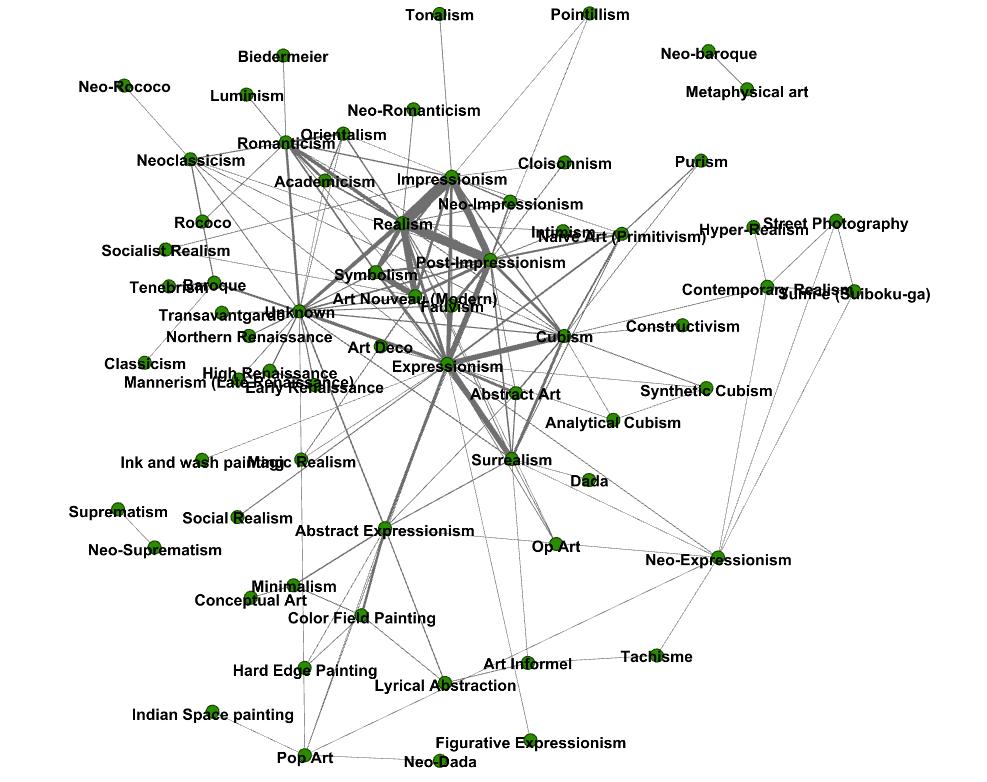

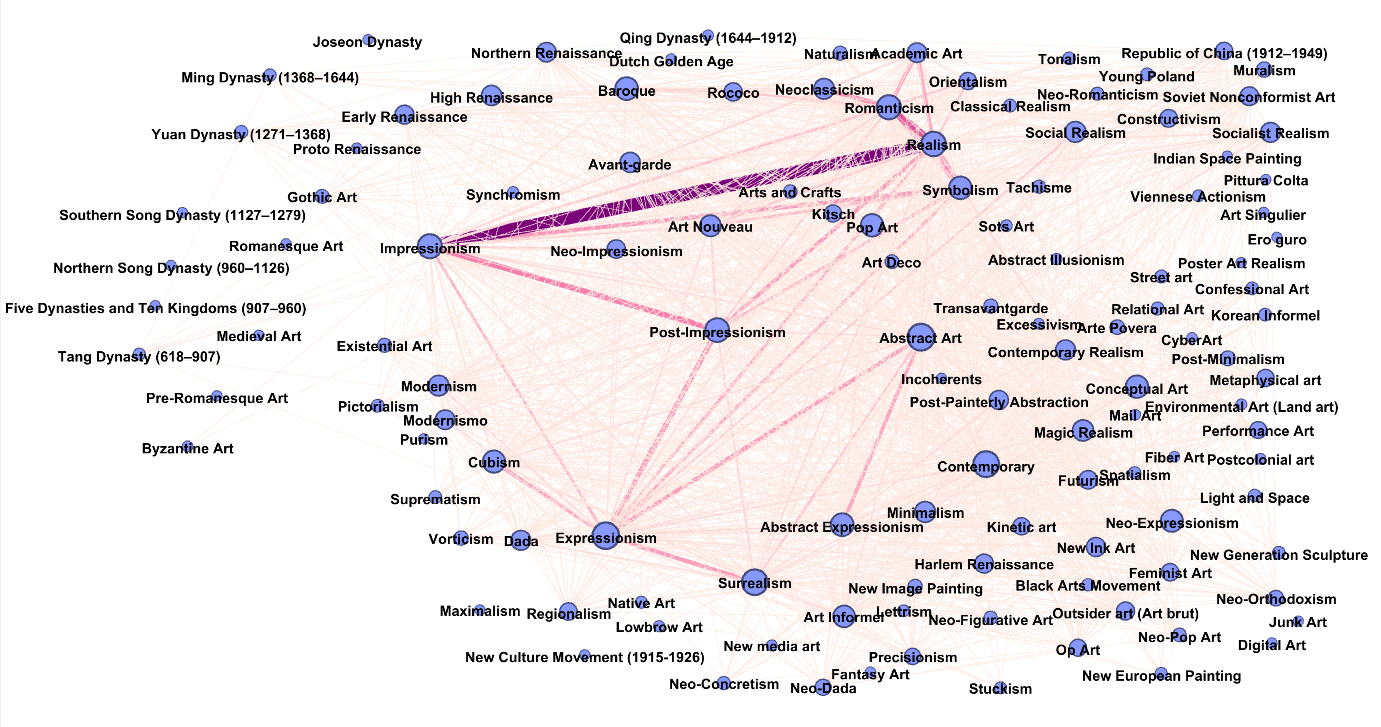

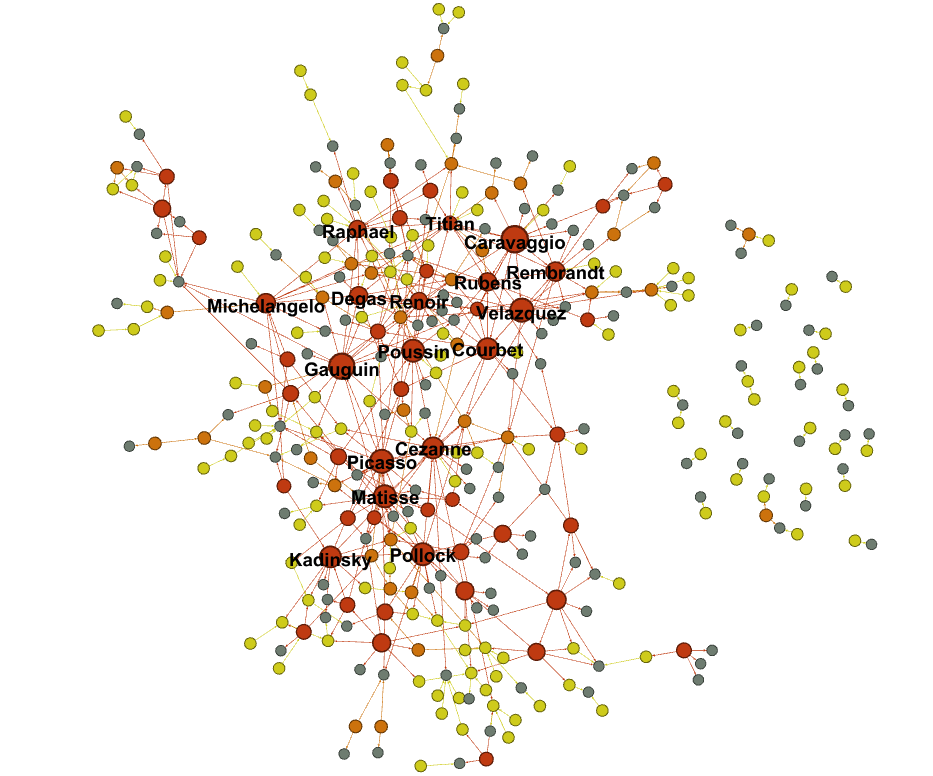

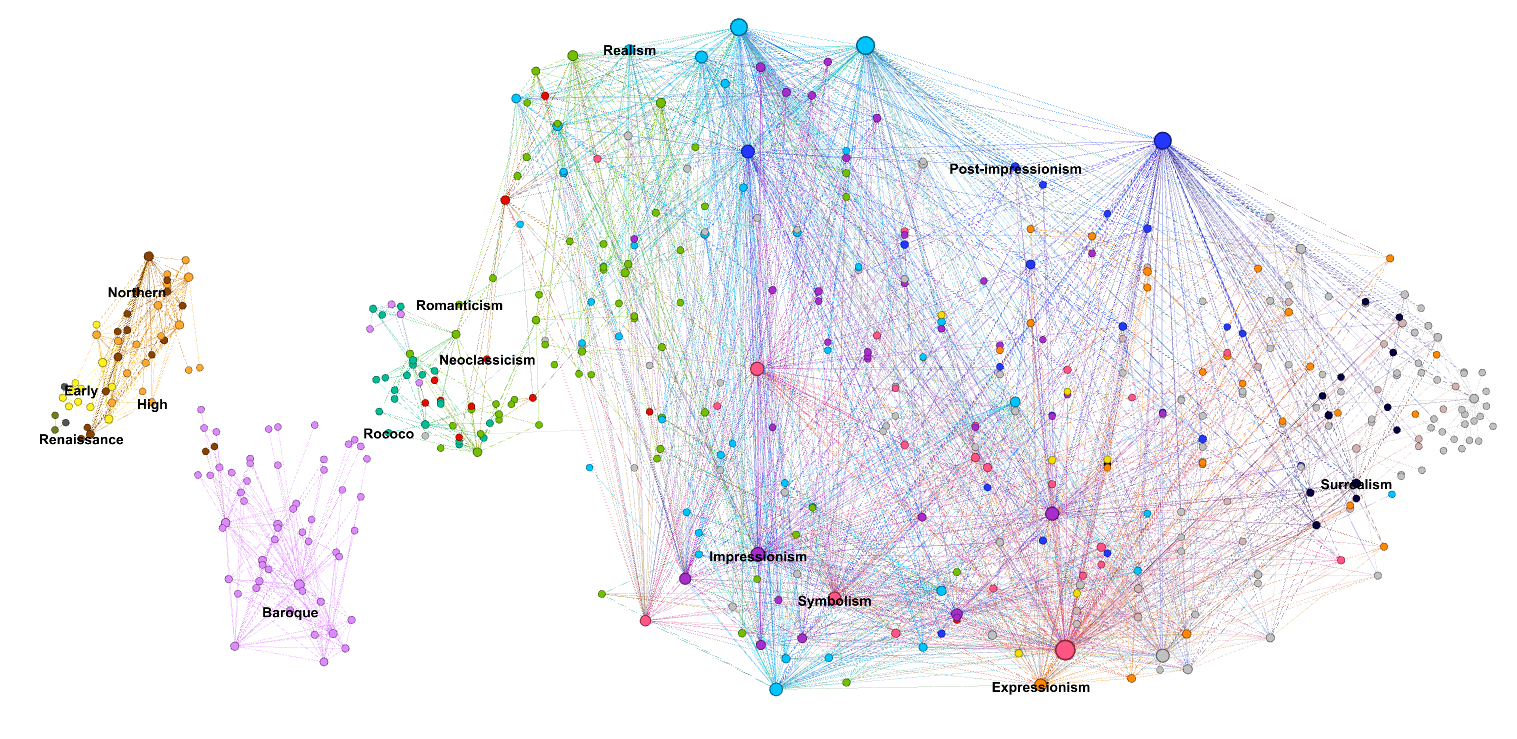

This last one was turned into a dynamic network and time represents the vertical axis, painters are aligned according to their birth year.

## 1. Power law distribution

Since the InfluencedOn network is a purely social network, it would be nice to see whether it has some typical properties of social networks. One of these is the power law distribution of degrees. Let's see if this is the case (just "pre-analysis"):

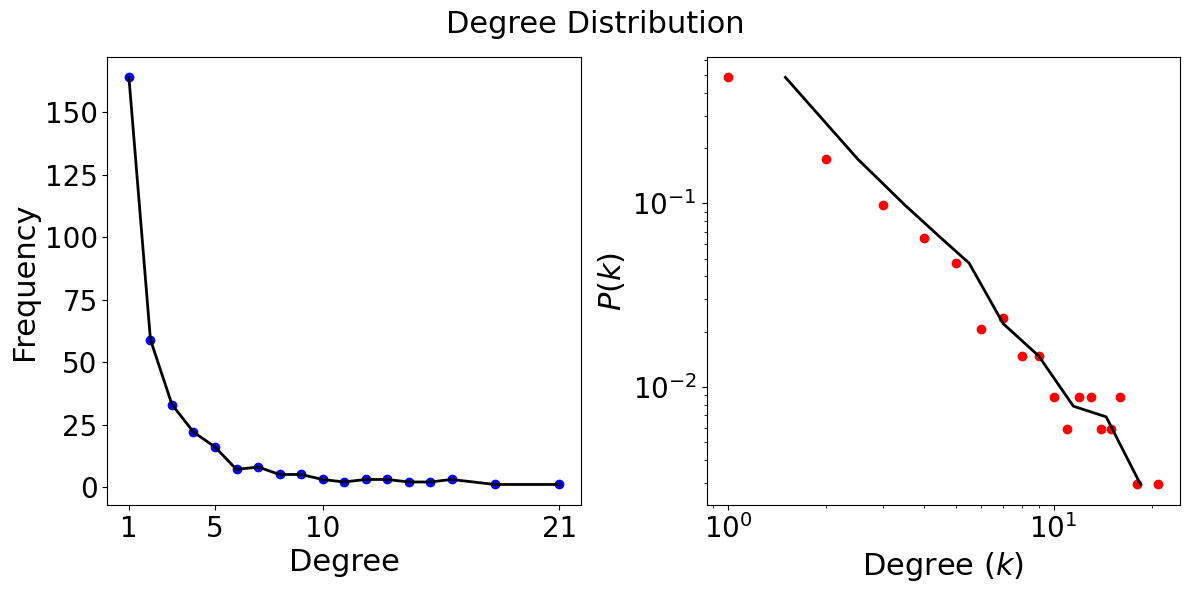

In [426]:
from operator import itemgetter
import powerlaw as pwl
from collections import Counter 

import matplotlib.pyplot as plt
from collections import Counter

def plot_deg_distr_lin(degrees, ax=None, label_turnoff = False, ticks_list = None):
    deg_distri=Counter(degrees)
    keys, values = zip(*sorted(deg_distri.items()))

    # Degree distribution
    if(ax is None): #Here we divide between if we want to just create a one plot figure, or use this plot as a part of a bigger figure
        plt.scatter(keys, values, color='blue')
        plt.plot(keys, values, color='black', linewidth=2)  # This line connects the points
        plt.xticks(ticks = ticks_list)
        #plt.yticks(fontsize=22)
        if(not label_turnoff):
            plt.xlabel('Degree', )
            plt.ylabel('Frequency', )
            plt.title('Degree Distribution', )
        return plt
    else:
        ax.scatter(keys, values, color='blue')
        ax.plot(keys, values, color='black', linewidth=2)  # This line connects the points
        if (ticks_list is not None):
            ax.set_xticks(ticks_list)
        ax.tick_params(axis='both', which='major', )
        if(not label_turnoff):
            ax.set_title('Degree Distribution', )
            ax.set_xlabel('Degree', )
            ax.set_ylabel('Frequency', )
        return ax
    
def plot_deg_distr_linandlog(degrees, ax=None):
    deg_distri=Counter(degrees)
    keys, values = zip(*sorted(deg_distri.items()))

    #This case is easier, we will use axes anyways, just a difference in whether the function creates them or not
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(12,6))

    if len(ax.shape)==1:
        first_ax = ax[0]
        second_ax = ax[1]
    elif len(ax.shape)==2:
        first_ax = ax[0,0]
        second_ax = ax[0,1]
    else:
        print("Too many dimensions") #Added this for the future
        return

    # Degree distribution
    first_ax.scatter(keys, values, color='blue')
    first_ax.plot(keys, values, color='black', linewidth=2)  # This line connects the points
    first_ax.set_xlabel('Degree', fontsize=22)
    first_ax.set_ylabel('Frequency', fontsize=22)
    first_ax.set_xticks([1,5,10,21])
    first_ax.tick_params(axis='both', which='major', labelsize=20)
    
    
    # Log-log plot
    x=[]; y=[]
    for i in sorted(deg_distri):   
        x.append(i); y.append(deg_distri[i]/len(G_influencedon))
    second_ax.set_yscale('log')
    second_ax.set_xscale('log')
    second_ax.plot(x,y,'ro')
    pwl.plot_pdf(degree, color='black', linewidth=2, ax=second_ax)
    second_ax.tick_params(axis='both', which='major', labelsize=20)
    second_ax.set_xlabel('Degree ($k$)', fontsize=22)
    second_ax.set_ylabel('$P(k)$', fontsize=22)

    fig.suptitle('Degree Distribution', fontsize=22)
    # Show the figure
    plt.tight_layout()
    if ax is None:
        plt.show()
    return ax

deg=dict(G_influencedon.degree()).values(); degree=list(deg)
plot_deg_distr_linandlog(degree);


At first glance, it seems to be the case, this seems similar to a negative power x^(-a) function. We need to do further analysis however, especially because this is a small network, not big enough to state this. One way to check is by fitting a power law distribution to the data, carried out by a Kolmogorov-Smirnov test.

In [167]:
pwl_distri=pwl.pdf(degree) #Could be done in NumPy
fit_function = pwl.Fit(degree)
print("alpha: ", round(fit_function.power_law.alpha,3),"\nsigma: " ,round(fit_function.power_law.sigma,3),"\ndistance: ", round(fit_function.power_law.D,3))


Calculating best minimal value for power law fit
alpha:  2.748  94%
sigma:  0.162 
distance:  0.116


A distance of 0.11 seems not bad (not good though), we have to understand that this is a small network and the power law distribution is not a perfect fit for it as it's so "spliny", probably if the network grew (by having more artists), the distance would be lower. Alpha is the slope (log-log), it is the exponent in the definition, which for scale-free networks is typically between 2 and 3, just like for us. We can actually compare whether other distributions fit better:

In [157]:
R1,p1 = fit_function.distribution_compare('power_law', 'exponential', normalized_ratio=True)
R2,p2 = fit_function.distribution_compare('power_law', 'lognormal_positive', normalized_ratio=True)
R3,p3 = fit_function.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
R4,p4 = fit_function.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True)

fits = pd.DataFrame({
    'Compared Distribution': ['Exponential', 'Lognormal', 'Truncated Power Law', 'Stretched Exponential'],
    'R': [R1, R2, R3, R4],
    'p': [p1, p2, p3, p4]
})
fits

Assuming nested distributions


,Compared Distribution,R,p
0,Exponential,1.458053,0.144826
1,Lognormal,0.344870,0.730192
2,Truncated Power Law,-1.096353,0.116494
3,Stretched Exponential,-0.452706,0.650760


Explanation: In each step, we compare the power law fit to an other fit. *R* is the loglikelihood ratio between the two distributions, if it is positive, then it's more likely that the fit is power law. The *p* is the p-value of the test that the better fit of the two is indeed a better fit.<br>
What we see is that whilst the exponential fit is considerably worse, a stretched exponential fit seems from this the most likely to be the best fit. This is not surprising, both the stretched exponential and the truncated power law are more general (they have 2 parameters for rate of change instead of 1). But we need to again think: the *p*-value of a truncated power law being better than just power law is low also because the two distributions are "similar", the exponential truncation is of lesser imp. We compare the truncated power law to a stretched exponential, and see which one is better:<br>
(note: our expectations is that the truncated power law is better, as this degree distribution seems to have some power property, and an exponential term is present also in the truncated power law definition)

In [158]:
fit_function.distribution_compare('truncated_power_law','stretched_exponential', normalized_ratio=True)

(3.4407791205217526, 0.0005800418287503853)

The p value is less than 0.0001, so there is not enough difference between the goodness of fit of the two distributions.

Let's see if this power law fit would pass the KS-test:

In [375]:
sim = fit_function.power_law.generate_random(339) #Varies a lot, must have been poorly implemented

#Histogram of sim
vals = plt.hist(sim, bins=40) # We had around 20 "bins" originally, somehow I found the value 40 for the histogram bin amount the best, smaller values put too many points in the first bin
plt.close() #Just need the bin values, not the plot

In [324]:
degree_pl = []
i = 1 #Bin index 
#Create a distribution, where for each bin *i*, the value *i* appears in the distribution as many times as the bin's "height"
for val in vals[0]:
    degree_pl += [i]*(int(val)) 
    i += 1

#Kolmogorov-Smirnov test
from scipy.stats import kstest
kstest(degree, degree_pl)

KstestResult(statistic=0.05014749262536873, pvalue=0.7883343507793026, statistic_location=1, statistic_sign=1)

The ~80% p-value seems promising, although we may have cheated a bit here while turning the continous distribution into a discrete one.<br>
I think it is fair to say that this seems like a scale-free network, with `alpha` parameter between 2 and 3.

Now let's see all networks' degree distributions. Since the Time-and-Place network is also a social network, we expect it to have some scale-free property too. Although style and movement networks are not, since one is built on top of painters, and the other is built on top of the first one, it'd be interesting to see if they have any similar phenomena among in their degree distribution (similar to reducing in value by some factor).

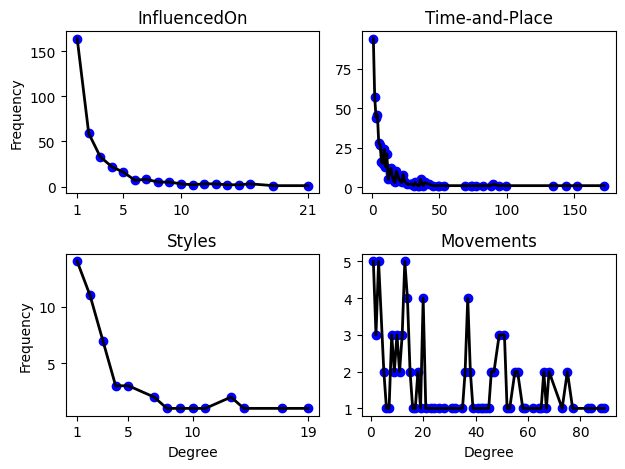

In [427]:
fig, axes = plt.subplots(2,2)

deg1=dict(G_influencedon.degree()).values(); degree1=list(deg1)
plot_deg_distr_lin(degree1, ax=axes[0][0], label_turnoff=True, ticks_list=[1,5,10,21])
deg2=dict(G_time_and_place.degree()).values(); degree2=list(deg2)
plot_deg_distr_lin(degree2, ax=axes[0][1], label_turnoff=True,)
deg3=dict(G_styles_threshold_100.degree()).values(); degree3=list(deg3)
plot_deg_distr_lin(degree3, ax=axes[1][0], label_turnoff=True,ticks_list=[1,5,10,19])
deg4=dict(G_movements_threshold_100.degree()).values(); degree4=list(deg4)
plot_deg_distr_lin(degree4, ax=axes[1][1], label_turnoff=True,)
axes[0][0].title.set_text("InfluencedOn"); axes[0][1].title.set_text("Time-and-Place"); axes[1][0].title.set_text("Styles"); axes[1][1].title.set_text("Movements");
axes[0][0].set_ylabel("Frequency"); axes[1][0].set_ylabel("Frequency"); axes[1][0].set_xlabel("Degree"); axes[1][1].set_xlabel("Degree");

plt.tight_layout()
plt.show()

They look fairly promising. The only if you were to include nodes with 0 degree, and just look at the shape, you'd see they all really look like somewhat power law networks (style would still be suspicious), exceptt the movement network, which whilst has a "bump" at the beginning, but it's not large enough (less than 20) and seems to be really ruined by many other bumps that seem like what'd come from combining a power law distribution with many Poisson's. It's not just "random" 1-wide 1-tall bumps appearing, these bumps are wider, and really seem to top in value in the middle, which suggests some external process (which may possibly be random) causing multimodality. It would be interesting to find out why this happens.<br>
As for tackling this, I had the assumption that maybe if you build a network on top of another network, somewhat like a higher scale view of the original network (not exactly our case now, but similar), you'd start having this phenomena of the power law being "ruined" by Poissons created by imperfections of "compressing the network". To my understanding, researchers in 2023 found a way to fairly well keep the scale-free distribution while creating higher scales: [Villegas et al.](https://www.nature.com/articles/s41567-022-01866-8)

Fits:

In [428]:
def fits_df(degree_list):
    # Initialize an empty DataFrame
    df = pd.DataFrame(columns=['alpha', 'D', 'Power law vs exponential', 'Power law vs lognormal'])

    for degree in degree_list:
        fit_function = pwl.Fit(degree)
        R1, p1 = fit_function.distribution_compare('power_law', 'exponential', normalized_ratio=True)
        R2, p2 = fit_function.distribution_compare('power_law', 'lognormal_positive', normalized_ratio=True)

        # Append the data to the DataFrame
        df = pd.concat([df, pd.DataFrame({'alpha': [fit_function.power_law.alpha], 
                                  'D': [fit_function.power_law.D], 
                                  'Power law vs exponential': [(R1,p1)], 
                                  'Power law vs lognormal': [(R2, p2)]})], ignore_index=True)
    return df

fits_df([degree1, degree2, degree3, degree4])

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


C:\Users\hanic\AppData\Local\Temp\ipykernel_33248\2193543216.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'alpha': [fit_function.power_law.alpha],


,alpha,D,Power law vs exponential,Power law vs lognormal
0,2.748105,0.116427,"(1.458053317022369, 0.1448258474850257)","(0.3448701073777836, 0.7301920243466706)"
1,2.639834,0.056138,"(2.353405596233072, 0.018602330755495618)","(0.10144777629312941, 0.9191950120714321)"
2,2.322875,0.123623,"(1.272760179700523, 0.203103155444182)","(0.5449578578228277, 0.5857825019811438)"
3,4.467004,0.133681,"(-2.618336982798858, 0.008835949882769202)","(-1.5108151482266874, 0.13083555412617867)"


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


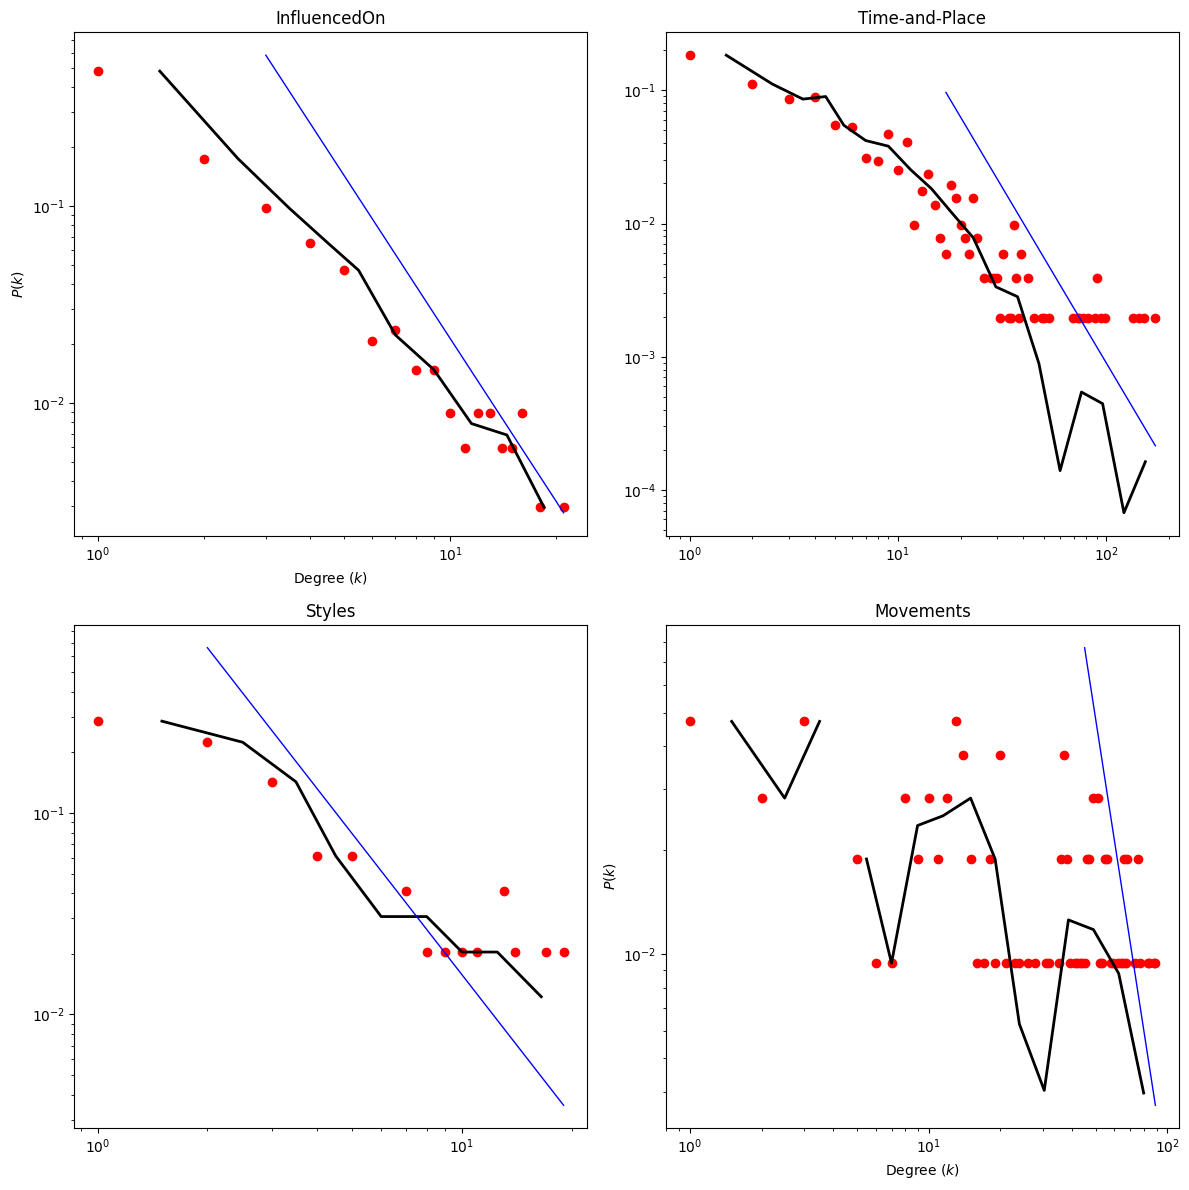

In [436]:
def plot_deg_dist_fit_log_single(degrees, ax=None, label_ignore=False):
    deg_distri=Counter(degrees)
    fit_f = pwl.Fit(degrees)
    
    # Log-log plot
    x=[]; y=[]
    for i in sorted(deg_distri):   
        x.append(i); y.append(deg_distri[i]/len(degrees))

    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111)

    ax.plot(x, y, 'ro')
    pwl.plot_pdf(degrees, color='black', linewidth=2, ax=ax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if not label_ignore:
        ax.set_xlabel('Degree ($k$)')
        ax.set_ylabel('$P(k)$')
        ax.set_title("Degree distribution")
    fit_f.power_law.plot_pdf(ax=ax, color='b', linestyle='-', linewidth=1, label='fit')

def plot_deg_dist_fit_log(degrees_list, label_ignore_list=None):
    if label_ignore_list is None:
        label_ignore_list = [False] * len(degrees_list)

    n = len(degrees_list)
    if n == 1:
        plot_deg_dist_fit_log_single(degrees_list[0], label_ignore=label_ignore_list[0])
        #return something
    else:
        rows = (n + 1) // 2
        fig, axes = plt.subplots(rows, 2, figsize=(12, 6*rows))
        axes = axes.flatten()
        for i, degrees in enumerate(degrees_list):
            plot_deg_dist_fit_log_single(degrees, ax=axes[i], label_ignore=label_ignore_list[i])
        plt.tight_layout()
        #plt.show()
        return fig, axes

fig,axes = plot_deg_dist_fit_log([degree1, degree2, degree3, degree4], label_ignore_list=[False, True, True, False])
axes[0].title.set_text("InfluencedOn"); axes[1].title.set_text("Time-and-Place"); axes[2].title.set_text("Styles"); axes[3].title.set_text("Movements")
plt.tight_layout()
plt.show()

While the KS distances are similar for all networks except the time-and-place network (which does much better), just by looking at the plots we can see how much differences one can observe. I'd think the second or third largest distance than biggest (as defined in the KS distance) would be a better measure here. That'd show what we can assume from the visualization: the two painter networks fit well, the style network is so-so, and the movement network is just not anything power-law.<br>
On other values, I would have thought that the Time-and-Place network would have a lower alpha value, as the "start" of the distribution (degree = 1) is considerably lower than the InfluencedOn network's start, which also "vanishes" faster. But these fits are not fitting enough as we can see from the plots.

Overall, we can say that as expected, the painter networks do have this scale-free phenomena as other social networks tend to have them too, but the more abstract networks, constructed from an attribute do not have a power law degree distribution. (On a side note, I expected the time-and-place network to be less scale-free, the bigger the time interval the more artists we have, so the "bins" increase in size, but a person can only make so many connections theoretically (loosely related here is the Dunbar effect), so the tail shouldn't get longer, which would decrease the fit goodness).

## 2. Small world property

As Watts and Strogatz published in 1998, social networks are not perfect in average shortest path length, as they differ from random networks, but get pretty close to that "optimum", and they are not perfectly clustered, but tend to have a high clustering ratio, comparable to a "ring network". They showed that some networks share this property by comparing the average path length and average clustering coefficient of the (nodes of the) network to a random network of the same size (V,E) and computing the same properties for that network, then compare them to each other.

Here, we do the same. I only do this analysis on the two painter networks, the other two networks after thresholding and deleting isoleated nodes don't seem to have small world properties.

In [487]:
#The NetworkX function for average shortest path length does not work for disconnected graphs, so we need to create our own function
def avg_shortest_path_length(G):
    #Firstly, a list of components
    G_copy = (G.copy()).to_undirected()
    components = list(nx.connected_components(G_copy))

    avgs = np.array([])
    lengths = np.array([])
    for component in components:
        if len(component) > 1: #Don't calculate for isolated nodes
            subgraph = G_copy.subgraph(component)
            avgs = np.append(avgs, nx.average_shortest_path_length(subgraph))
            lengths = np.append(lengths, len(component))
    avg = np.sum(avgs*lengths)/np.sum(lengths) #Weighted average: each average has the weight of how many nodes are in the component (basically, this equals summing all node averages, then dividing by the total number of nodes)
    return avg


G_random_1 = nx.erdos_renyi_graph(G_influencedon.number_of_nodes(), 2*G_influencedon.number_of_edges()/(G_influencedon.number_of_nodes()**2), seed=42)
G_random_2 = nx.erdos_renyi_graph(G_time_and_place.number_of_nodes(), 2*G_time_and_place.number_of_edges()/(G_time_and_place.number_of_nodes()**2), seed=42)
graphs = [G_influencedon, G_random_1, G_time_and_place, G_random_2]
data = []
for G in graphs:
    cc = nx.average_clustering(G)
    pl = avg_shortest_path_length(G)
    v = G.number_of_nodes()
    e = G.number_of_edges()
    data.append([cc, pl, v, e, ])

# Create DataFrame
df = pd.DataFrame(data, columns=['CC', 'Path Length', 'V', 'E',], 
                  index=['G_influencedon','G_random_1', 'G_timeandplace', 'G_random_2'])

df

,CC,Path Length,V,E
G_influencedon,0.031402,4.192547,339,502
G_random_1,0.008765,5.060365,339,522
G_timeandplace,0.628949,2.804155,512,2806
G_random_2,0.022812,2.875512,512,2741


Interestingly, the path length ratio came out to be even better than random graphs. I had such results before on different social networks, it seems to be a case when there are too low amount of edges in the network, may be an influence in the first case. In the second case, I don't think we this is supposed to happen, we have enough edges. In fact, to me the 2.8 ratio is very low, you'd expect something quite higher as this network depends a lot on time, and therefore is very limited on "cross-cluster/hub connecting weak ties" (there is no possible way, that a painter born in the 1700s has a common connection with someone born in the 1900s). A possible explanation might be that the definition is not "proper" but to be fair, the definition for disconnected networks is not agreed on, some just output infinity as any disconnected node pair has infinite distance, [Wikipedia](https://en.wikipedia.org/wiki/Average_path_length) says disconnected points should have 0 distance which is very unintuitive, and even when calculating averages just within components, the way you combine the different component averages is also defined multiple ways. We can try the d(v_i,v_j)=0 if v_i and v_j are disconnected definition, and also check what'd happen if we just look at the largest component:

In [495]:
def avg_shortest_path_length_0_disconnected_distance(G):
    # Firstly, a list of components
    G_copy = (G.copy()).to_undirected()
    components = list(nx.connected_components(G_copy))

    total_path_length = 0
    total_pairs = G_copy.number_of_nodes() * (G_copy.number_of_nodes() - 1) / 2  #All possible pairs of nodes

    for component in components:
        # Create a subgraph for this component
        subgraph = G_copy.subgraph(component)
        if len(component) > 1:  # Don't calculate for isolated nodes
            total_path_length += nx.average_shortest_path_length(subgraph) * len(component) * (len(component) - 1)/2
            

    avg = total_path_length / total_pairs  # Average path length
    return avg

G_influencedon_biggest_component = max(nx.connected_components(G_influencedon.to_undirected()), key=len)
G_influencedon_biggest_component = G_influencedon.subgraph(G_influencedon_biggest_component)
G_random_sized_influencedon_biggest_component = nx.erdos_renyi_graph(G_influencedon_biggest_component.number_of_nodes(), 2*G_influencedon_biggest_component.number_of_edges()/(G_influencedon_biggest_component.number_of_nodes()**2), seed=42)


G_time_and_place_biggest_component = max(nx.connected_components(G_time_and_place), key=len)
G_time_and_place_biggest_component = G_time_and_place.subgraph(G_time_and_place_biggest_component)
G_random_sized_time_and_place_biggest_component = nx.erdos_renyi_graph(G_time_and_place_biggest_component.number_of_nodes(), 2*G_time_and_place_biggest_component.number_of_edges()/(G_time_and_place_biggest_component.number_of_nodes()**2), seed=42)

#Copilot code:
data = {
    "Graph": [
        "InfluencedOn", 
        "Random (InfluencedOn)", 
        "InfluencedOn biggest component", 
        "Random (InfluencedOn biggest component)",  
        "Time-and-Place", 
        "Random (Time-and-Place)",
        "Time-and-Place biggest component",
        "Random (Time-and-Place biggest component)"
    ],
    "Nodes": [
        G_influencedon.number_of_nodes(),
        G_random_1.number_of_nodes(),
        G_influencedon_biggest_component.number_of_nodes(),
        G_random_sized_influencedon_biggest_component.number_of_nodes(),
        G_time_and_place.number_of_nodes(),
        G_random_2.number_of_nodes(),
        G_time_and_place_biggest_component.number_of_nodes(),
        G_random_sized_time_and_place_biggest_component.number_of_nodes(),
    ],
    "Edges": [
        G_influencedon.number_of_edges(),
        G_random_1.number_of_edges(),
        G_influencedon_biggest_component.number_of_edges(),
        G_random_sized_influencedon_biggest_component.number_of_edges(),
        G_time_and_place.number_of_edges(),
        G_random_2.number_of_edges(),
        G_time_and_place_biggest_component.number_of_edges(),
        G_random_sized_time_and_place_biggest_component.number_of_edges(),
    ],
    "Original avg shortest path length": [
        round(avg_shortest_path_length_0_disconnected_distance(G_influencedon), 3),
        round(avg_shortest_path_length_0_disconnected_distance(G_random_1), 3),
        round(avg_shortest_path_length_0_disconnected_distance(G_influencedon_biggest_component), 3),
        round(avg_shortest_path_length_0_disconnected_distance(G_random_sized_influencedon_biggest_component), 3),
        round(avg_shortest_path_length_0_disconnected_distance(G_time_and_place), 3),
        round(avg_shortest_path_length_0_disconnected_distance(G_random_2), 3),
        round(avg_shortest_path_length_0_disconnected_distance(G_time_and_place_biggest_component), 3),
        round(avg_shortest_path_length_0_disconnected_distance(G_random_sized_time_and_place_biggest_component), 3),
    ],
    "Modified avg shortest path length": [
        round(avg_shortest_path_length(G_influencedon), 3),
        round(avg_shortest_path_length(G_random_1), 3),
        (round(avg_shortest_path_length(G_influencedon_biggest_component), 3), "same"),
        round(avg_shortest_path_length(G_random_sized_influencedon_biggest_component), 3),
        round(avg_shortest_path_length(G_time_and_place), 3),
        round(avg_shortest_path_length(G_random_2), 3),
        (round(avg_shortest_path_length(G_time_and_place_biggest_component), 3), "same"),
        round(avg_shortest_path_length(G_random_sized_time_and_place_biggest_component), 3),
    ],
    "Clustering coefficient": [
        round(nx.average_clustering(G_influencedon), 3),
        round(nx.average_clustering(G_random_1), 3),
        round(nx.average_clustering(G_influencedon_biggest_component), 3),
        round(nx.average_clustering(G_random_sized_influencedon_biggest_component), 3),
        round(nx.average_clustering(G_time_and_place), 3),
        round(nx.average_clustering(G_random_2), 3),
        round(nx.average_clustering(G_time_and_place_biggest_component), 3),
        round(nx.average_clustering(G_random_sized_time_and_place_biggest_component), 3),
    ],
}

df = pd.DataFrame(data, index=data["Graph"]).drop(columns=["Graph"])
df

,Nodes,Edges,Original avg shortest path length,Modified avg shortest path length,Clustering coefficient
InfluencedOn,339,502,3.439,4.193,0.031
Random (InfluencedOn),339,522,4.582,5.06,0.009
InfluencedOn biggest component,290,474,4.701,"(4.701, same)",0.037
Random (InfluencedOn biggest component),290,486,4.361,4.679,0.007
Time-and-Place,512,2806,1.889,2.804,0.629
Random (Time-and-Place),512,2741,2.876,2.876,0.023
Time-and-Place biggest component,400,2397,3.032,"(3.032, same)",0.641
Random (Time-and-Place biggest component),400,2388,2.681,2.681,0.030


In [ ]:
import plotly.figure_factory as ff

fig = ff.create_table(df)
fig.show()

Indeed we see that only looking at the biggest component and creating a random graph of that size, the path length is lower for the random graph. Switching to the original definition did not really make things any better, it may even have made the differences between random graphs and original graphs higher. Just from the row "Random (InfluencedOn biggest component)" and above, I see that isolated nodes cause a huge problem, how much more they decrease the average path length in the original definition. Think about it: "the most efficient" a node can get in path lengths is by the original definition is if it's isolated: every distance from it is 0. Whereas the most inefficient, most "distant" a node can get is if it's connected to only one node (a specific one, that'd maximalize the average shortest path length), because any new edges connected to the node would decrease the average path length. It's not a good definition, I'll stick to the one we created (which also falls to this problem, that by connecting two disconnected nodes you may increase the average path length, but at least it does not give a "bonus" for being disconnected (by 0 distance)).

We can observe that interestingly, if we just look at the complete networks, the average path length is even lower than the associated random graph's. Realistically, this has to be caused by the bad handling of disconnected nodes, because when we only look at the biggest component, suddenly there is a big jump in average path length, whereas for the random graph (since we create a smaller random graph, that is denser) we even see a decrease. For just one component (luckily the Time-and-Place biggest component random graph also came out to be connected), we indeed see that the random graph's average path length is lower. In any case, since random graphs have low average path lengths, we see that these networks, just like small world networks, have low average path lengths too.<br>
As for the clustering coefficient, in all cases we see multiple times higher values than the random graph's, so that also checks out. 

We can thus conclude that these networks have small world properties. This was also expected, as these are social networks, but I must say that again, the time-and-place network I would have assumed to fail this test, since it has such a long time interval, based on [this](https://en.wikipedia.org/wiki/Small-world_network#Examples_of_non-small-world_networks) (see: non-small world networks).

## 3. TimeAndPlace dynamic analysis

We have time data of painters such as birth year, we can do some dynamic analysis with it. Since we saw quite high clustering, we may look into the number of triangles too, since it's related (a node's two neighbors being neighbors create a triangle together). For some more social contagion/homophily type analysis, we may even analyze the number of connections that are between artists of the same movement (this would be mostly useful from the time of romanticism and neoclassicism, when many movements are present consistently in the network, not just one or two).<br>

Sadly, when creating the graphs, no node attributes were stored:

In [498]:
set([k for n in G_time_and_place.nodes for k in G_time_and_place.nodes[n].keys()])

set()

Thankfully we can easily add them:

In [500]:
births = [int(artists[artists['artist'] == artist]['birth_year'].iloc[0]) for artist in G_time_and_place.nodes()]
#firsts = [int(artists[artists['artist'] == artist]['FirstYear'].iloc[0]) for artist in G_time_and_place.nodes()]
#lasts = [int(artists[artists['artist'] == artist]['LastYear'].iloc[0]) for artist in G_time_and_place.nodes()]

nx.set_node_attributes(G_time_and_place, dict(zip(G_time_and_place.nodes(), births)), 'birth_year')
#nx.set_node_attributes(G_time_and_place, dict(zip(G_time_and_place.nodes(), firsts)), 'first_year')
#nx.set_node_attributes(G_time_and_place, dict(zip(G_time_and_place.nodes(), lasts)), 'last_year')

# Order of birth_year
birth_years = sorted(births)
birth_years_order = [birth_years.index(birth_year) + 1 for birth_year in births]
birth_years_order_dict = dict(zip(G_time_and_place.nodes(), birth_years_order))
nx.set_node_attributes(G_time_and_place, birth_years_order_dict, 'birth_year_order_1_to_N')

#Add artist movement to nodes
movement_dict = {artist: artists[artists['artist'] == artist]['movement'].iloc[0] for artist in G_time_and_place.nodes()}
nx.set_node_attributes(G_time_and_place, movement_dict, 'movement')

print(set([k for n in G_time_and_place.nodes for k in G_time_and_place.nodes[n].keys()]))
print("Biggest index: ", max(birth_years_order))
G_time_and_place.nodes['Ad Reinhardt']

{'birth_year_order_1_to_N', 'movement', 'birth_year'}
Biggest index:  512


{'birth_year': 1913,
 'birth_year_order_1_to_N': 465,
 'movement': 'Abstract Expressionism'}

### Triangular closure:

In [572]:
# Initialize the lists to store the counts and ratios
open_triangle_counts = []
closed_triangle_counts = []
open_to_closed_ratio_year = []

# Iterate through the nodes to create subgraphs
for i in range(1, 513):
    # Create a subgraph
    subgraph_nodes = [node for node, attrs in G_time_and_place.nodes(data=True) if attrs.get('birth_year_order_1_to_N', 0) <= i]
    subgraph = G_time_and_place.subgraph(subgraph_nodes)

    # Closed triangles (all three edges are present)
    closed_triangles = sum(nx.triangles(subgraph).values())//3
    closed_triangle_counts.append(closed_triangles)

    # Open triangles (two edges with a missing third edge)
    open_triangles = 0
    for node in subgraph:
        neighbors = set(nx.neighbors(subgraph, node))
        for neighbor1 in neighbors:
            for neighbor2 in neighbors:
                if neighbor1 != neighbor2 and not subgraph.has_edge(neighbor1, neighbor2):
                    open_triangles += 1
    open_triangle_counts.append(open_triangles) #Don't have to divide by 3, as the open triangles are "unique" in counting

    # Calculate the ratio and add it to the list
    if closed_triangles > 0:
        open_to_closed_ratio_year.append(open_triangles / closed_triangles)
    else:
        open_to_closed_ratio_year.append(0)

#### Comparing to random graphs:

In [565]:
import itertools
#Random graph attributes
n = 512
edges = 2811
p = edges / (n * (n - 1) / 2)

#Generate 100 random graphs and average the number of triangles
random_graphs = []
for i in range(100):
    random_graph = nx.erdos_renyi_graph(n, p)
    random_graphs.append(random_graph)

turn = 0
open_to_closed_ratio_random= np.array([])
open_triangle_averages_random = np.array([])
closed_triangle_averages_random = np.array([])

for random_graph in random_graphs:
    # Initialize lists to store the count of open and closed triangles for the random graph
    open_triangle_counts_random = np.array([])
    closed_triangle_counts_random = np.array([])
    turn += 1

    # Identifying open and closed triangles for the random graph
    for i in range(1, n + 1):
        # Creating a subgraph with nodes less or equal to i
        subgraph = random_graph.subgraph(range(i))

        # Counting closed triangles
        closed_triangles = sum(nx.triangles(subgraph).values()) // 3

        # Counting open triangles
        open_triangles = 0
        for node in subgraph:
            neighbors = set(nx.neighbors(subgraph, node))
            for neighbor1, neighbor2 in itertools.combinations(neighbors, 2):
                if not subgraph.has_edge(neighbor1, neighbor2):
                    open_triangles += 1
        #Don't have to divide by 3

        # Append counts to respective lists
        open_triangle_counts_random = np.append(open_triangle_counts_random, open_triangles)
        closed_triangle_counts_random = np.append(closed_triangle_counts_random, closed_triangles)

    # Calculate the ratio of open to closed triangles for the random graph
    ratios_random = [open_t / closed_t if closed_t > 0 else float('inf') for open_t, closed_t in zip(open_triangle_counts_random, closed_triangle_counts_random)]
    ratios_random = np.array(ratios_random)
    if turn == 1:
        open_to_closed_ratio_random= ratios_random
        open_triangle_averages_random = open_triangle_counts_random
        closed_triangle_averages_random = closed_triangle_counts_random
    else: #Average the ratios
        open_to_closed_ratio_random= (open_to_closed_ratio_random*turn + ratios_random)/(turn+1)
        open_triangle_averages_random = (open_triangle_averages_random*turn + open_triangle_counts_random)/(turn+1)
        closed_triangle_averages_random = (closed_triangle_averages_random*turn + closed_triangle_counts_random)/(turn+1)



We expected lot less 

#### Year-time analysis:

In [579]:
#Triangle closure, but not by birth year order, but by 10 year intervals

# Initializing a list to store the number of triangles for each graph
closed_triangle_counts_yearly = []
open_triangle_counts_yearly = [] # 3 nodes with 2 edges between them
ratio_counts_yearly = []
min_year = [attrs['birth_year'] for node, attrs in G_time_and_place.nodes(data=True) if attrs['birth_year_order_1_to_N'] == 1][0]
max_year = [attrs['birth_year'] for node, attrs in G_time_and_place.nodes(data=True) if attrs['birth_year_order_1_to_N'] == 512][0]

# Iterating through the nodes to create subgraphs and count triangles
for i in range(min_year, max_year+1, 10):
    # Creating a subgraph with nodes having 'birth_year_order_1_to_N' less or equal to i
    subgraph_nodes = [node for node, attrs in G_time_and_place.nodes(data=True) if attrs['birth_year'] <= i]
    subgraph = G_time_and_place.subgraph(subgraph_nodes)

    # Counting the number of triangles in the subgraph
    closed_triangles = sum(nx.triangles(subgraph).values()) // 3  # Each triangle is counted three times
    closed_triangle_counts_yearly.append(closed_triangles)
    # Counting the number of open triangles in the subgraph: 3 nodes with 2 edges between them
    open_triangles = 0
    for node in subgraph:
        neighbors = set(nx.neighbors(subgraph, node))
        for neighbor1, neighbor2 in itertools.combinations(neighbors, 2):
            if not subgraph.has_edge(neighbor1, neighbor2):
                open_triangles += 1
    
    open_triangle_counts_yearly.append(open_triangles)
    if closed_triangles > 0:
        ratio_counts_yearly.append(open_triangles/closed_triangles)
    else:
        ratio_counts_yearly.append(0)

### Combined plot

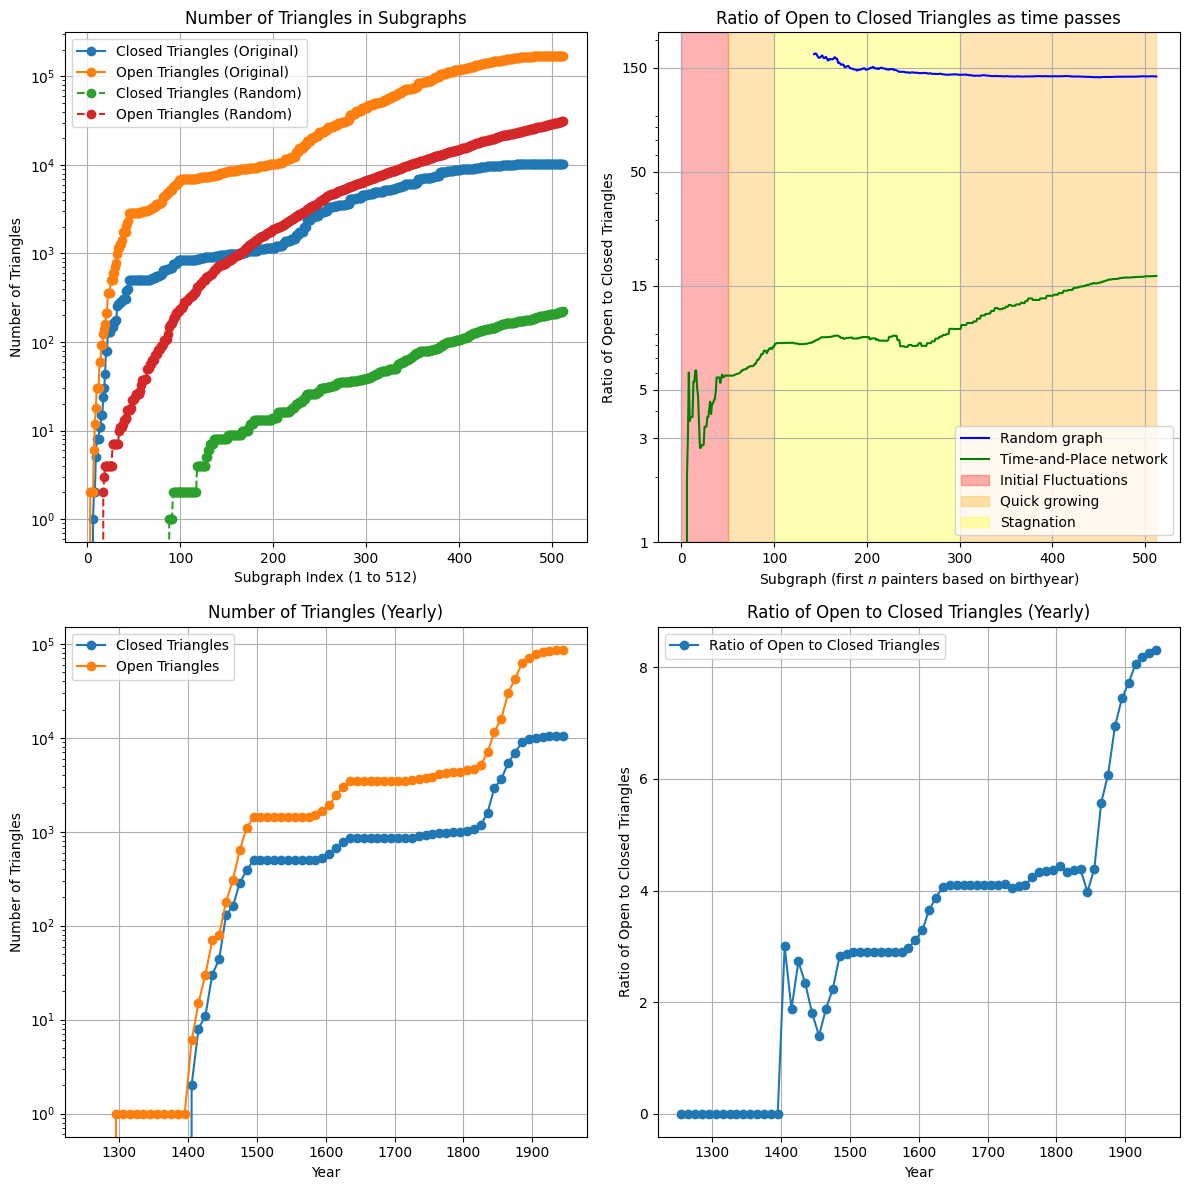

In [578]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot the number of triangles for each subgraph
axes[0, 0].plot(range(1, 513), closed_triangle_counts, marker='o', label='Closed Triangles (Original)')
axes[0, 0].plot(range(1, 513), open_triangle_counts, marker='o', label='Open Triangles (Original)')
axes[0, 0].plot(range(1, 513), closed_triangle_counts_random, marker='o', linestyle='dashed', label='Closed Triangles (Random)')
axes[0, 0].plot(range(1, 513), open_triangle_counts_random, marker='o', linestyle='dashed', label='Open Triangles (Random)')
axes[0, 0].set_title('Number of Triangles in Subgraphs')
axes[0, 0].set_xlabel('Subgraph Index (1 to 512)')
axes[0, 0].set_ylabel('Number of Triangles')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True)
axes[0, 0].legend()

# Plot the ratio of open to closed triangles as time passes
axes[0, 1].plot(range(1, 513), open_to_closed_ratio_random, color='blue', label='Random graph')
axes[0, 1].plot(range(1, 513), open_to_closed_ratio_year, color='green', label='Time-and-Place network')
axes[0, 1].set_title('Ratio of Open to Closed Triangles as time passes')
axes[0, 1].set_xlabel('Subgraph (first $n$ painters based on birthyear)')
axes[0, 1].set_ylabel('Ratio of Open to Closed Triangles')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True)
axes[0, 1].set_yticks([10**0, 10**0.7, 10**0.477, 10**1.177, 10**1.7, 10**2.177])
axes[0, 1].set_yticklabels(['1', '5', '3', '15', '50','150'])
axes[0, 1].axvspan(0, 50, color='red', alpha=0.3, label='Initial Fluctuations')
axes[0, 1].axvspan(50, 100, color='orange', alpha=0.3, label='Quick growing')
axes[0, 1].axvspan(100, 300, color='yellow', alpha=0.3, label='Stagnation')
axes[0, 1].axvspan(300, 512, color='orange', alpha=0.3)
axes[0, 1].legend()



# Plot the number of triangles yearly
axes[1, 0].plot(range(min_year, max_year+1,10), closed_triangle_counts_yearly, marker='o', label='Closed Triangles')
axes[1, 0].plot(range(min_year, max_year+1,10), open_triangle_counts_yearly, marker='o', label='Open Triangles')
axes[1, 0].set_title('Number of Triangles (Yearly)')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Number of Triangles')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)
axes[1, 0].legend()

# Plot the ratio of open to closed triangles yearly
axes[1, 1].plot(range(min_year, max_year+1,10), ratio_counts_yearly, marker='o', label='Ratio of Open to Closed Triangles')
axes[1, 1].set_title('Ratio of Open to Closed Triangles (Yearly)')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Ratio of Open to Closed Triangles')
axes[1, 1].grid(True)
axes[1, 1].legend()

# Display the plots
plt.tight_layout()
plt.show()

### "Cultural dynamics" (type of social contagion where people pick up an attribute from their friends):

Connections with same movement:

In [580]:
good_connection_counts_discrete = [] #Heteregeneous connections
bad_connection_counts_discrete = []
good_to_total_ratio_discrete = []
G = G_time_and_place #less writing


# Iterate through the nodes to create subgraphs
for i in range(1, 513):
    # Create a subgraph
    subgraph_nodes = [node for node, attrs in G.nodes(data=True) if attrs['birth_year_order_1_to_N'] <= i]
    subgraph = G.subgraph(subgraph_nodes)

    # Count good and bad connections in the subgraph
    good_count = 0
    bad_count = 0
    for node1, node2 in subgraph.edges():
        movement1 = subgraph.nodes[node1].get('movement', None)
        movement2 = subgraph.nodes[node2].get('movement', None)
        if movement1 and movement2:
            if movement1 == movement2:
                good_count += 1
            else:
                bad_count += 1

    # Add the counts to the respective lists
    good_connection_counts_discrete.append(good_count)
    bad_connection_counts_discrete.append(bad_count)
    if good_count + bad_count > 0:
        good_to_total_ratio_discrete.append(good_count / (good_count + bad_count))
    else:
        good_to_total_ratio_discrete.append(0)


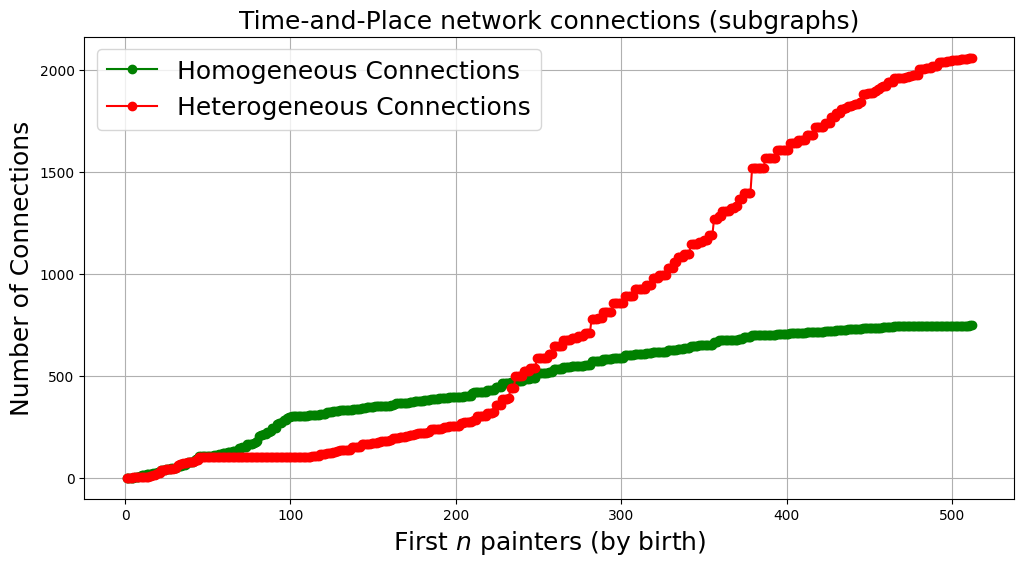

In [609]:
# Visualizing the counts
plt.figure(figsize=(12, 6))
plt.plot(range(1, 513), good_connection_counts_discrete, marker='o', color='green', label='Homogeneous')
plt.plot(range(1, 513), bad_connection_counts_discrete, marker='o', color='red', label='Heterogeneous')
plt.title('Time-and-Place network connections (subgraphs)', fontsize = 18)
plt.xlabel('First $n$ painters (by birth)', fontsize = 18)
plt.ylabel('Number of Connections', fontsize = 18)
plt.legend(fontsize = 18)
plt.grid(True)
plt.show()


#### Year-time analysis:

In [584]:
# Initialize lists to store the counts
good_connection_counts_yearly = []
bad_connection_counts_yearly = []
good_to_total_ratio = []
G = G_time_and_place
min_year = [attrs['birth_year'] for node, attrs in G.nodes(data=True) if attrs['birth_year_order_1_to_N'] == 1][0]
max_year = [attrs['birth_year'] for node, attrs in G.nodes(data=True) if attrs['birth_year_order_1_to_N'] == 512][0]



# Iterate through the nodes to create subgraphs
for i in range(min_year, max_year+1, 10):
    # Create a subgraph
    subgraph_nodes = [node for node, attrs in G.nodes(data=True) if attrs['birth_year'] <= i]
    subgraph = G.subgraph(subgraph_nodes)

    # Count good and bad connections in the subgraph
    good_count = 0
    bad_count = 0
    for node1, node2 in subgraph.edges():
        movement1 = subgraph.nodes[node1].get('movement', None)
        movement2 = subgraph.nodes[node2].get('movement', None)
        if movement1 and movement2:
            if movement1 == movement2:
                good_count += 1
            else:
                bad_count += 1

    # Add the counts to the respective lists
    good_connection_counts_yearly.append(good_count)
    bad_connection_counts_yearly.append(bad_count)
    if good_count + bad_count > 0:
        good_to_total_ratio.append(good_count / (good_count + bad_count))
    else:
        good_to_total_ratio.append(0)

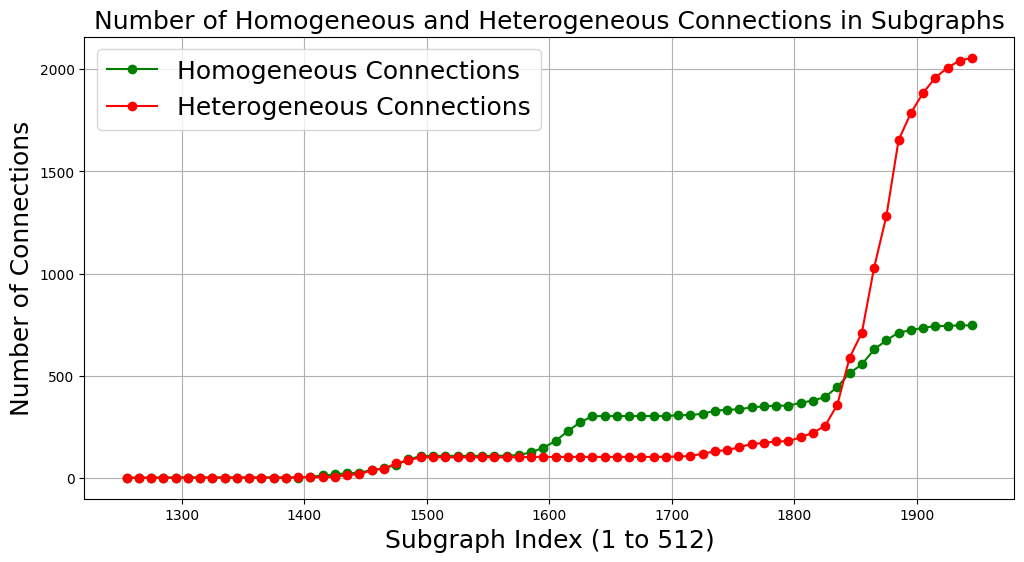

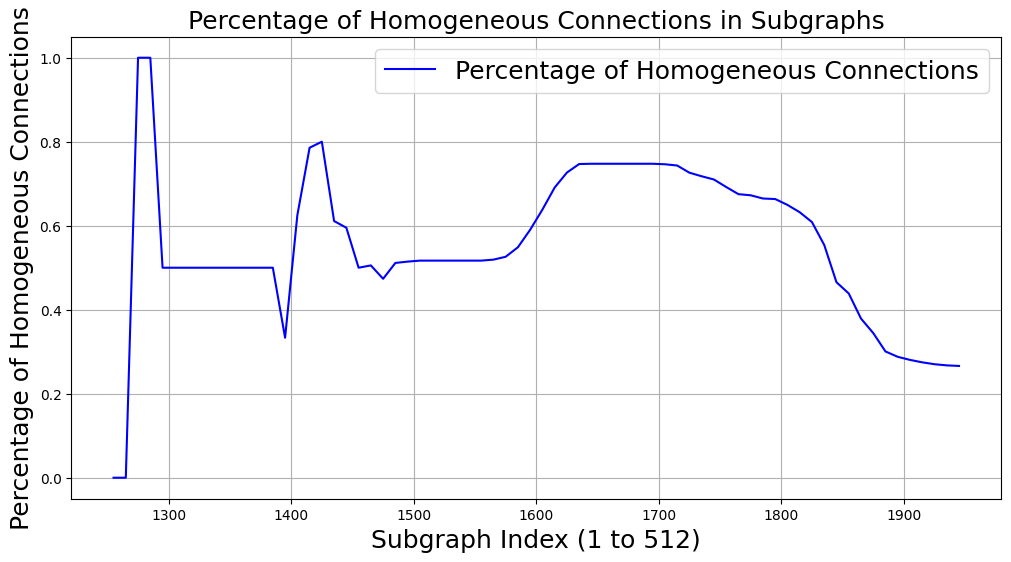

In [585]:
# Visualizing the counts
plt.figure(figsize=(12, 6))
plt.plot(range(min_year, max_year+1, 10), good_connection_counts_yearly, marker='o', color='green', label='Homogeneous Connections')
plt.plot(range(min_year, max_year+1, 10), bad_connection_counts_yearly, marker='o', color='red', label='Heterogeneous Connections')
plt.title('Number of Homogeneous and Heterogeneous Connections in Subgraphs', fontsize = 18)
plt.xlabel('Subgraph Index (1 to 512)', fontsize = 18)
plt.ylabel('Number of Connections', fontsize = 18)
plt.legend(fontsize = 18)
plt.grid(True)
plt.show()

# Visualizing the ratio in a separate graph
plt.figure(figsize=(12, 6))
plt.plot(range(min_year, max_year+1, 10), good_to_total_ratio, color='blue', label='Percentage of Homogeneous Connections')
plt.title('Percentage of Homogeneous Connections in Subgraphs', fontsize = 18)
plt.xlabel('Subgraph Index (1 to 512)', fontsize = 18)
plt.ylabel('Percentage of Homogeneous Connections', fontsize = 18)
plt.legend(fontsize = 18)
plt.grid(True)
plt.show()


#### Comparison to random graphs:

We need to also randomly add the attributes to the random graphs "fairly", so I'll get the (movement, count) pairs for the original graph, and randomly add them to the random graphs. Let's get the pairs first:

In [592]:
#Get movement attribute counts
np.random.seed(20001104)

movement_counts = {}
for node, attrs in G_time_and_place.nodes(data=True):
    movement = attrs.get('movement', None)
    if movement:
        movement_counts[movement] = movement_counts.get(movement, 0) + 1

for node in random_graph.nodes():
    random_graph.nodes[node]['movement'] = np.random.choice(list(movement_counts.keys()), p=[count/512 for count in movement_counts.values()])

#List random graph movement counts
random_movement_counts = {}
for node, attrs in random_graph.nodes(data=True):
    movement = attrs.get('movement', None)
    if movement:
        random_movement_counts[movement] = random_movement_counts.get(movement, 0) + 1


print("Original graph post-impressionist movement painters:", movement_counts['Post-Impressionism'])
print("Random graph:", random_movement_counts['Post-Impressionism'])

Original graph post-impressionist movement painters: 22
Random graph: 23


In [593]:
np.random.seed(20001104)

#Random graph of the same size
n = 512
edges = 2811
p = edges / (n * (n - 1) / 2)

#Generate 100 random graphs and average the ratio of homogeneous connections
random_graphs = []
for i in range(100):
    random_graph = nx.erdos_renyi_graph(n, p)
    random_graphs.append(random_graph)

turn = 0
connection_ratios_random = np.array([])
min_year = [attrs['birth_year'] for node, attrs in G.nodes(data=True) if attrs['birth_year_order_1_to_N'] == 1][0]
max_year = [attrs['birth_year'] for node, attrs in G.nodes(data=True) if attrs['birth_year_order_1_to_N'] == 512][0]

for random_graph in random_graphs:
    # Add random movement attribute to each node, proportional to the movement counts in the original graph
    for node in random_graph.nodes():
        random_graph.nodes[node]['movement'] = np.random.choice(list(movement_counts.keys()), p=[count/512 for count in movement_counts.values()])
    # Initialize lists to store the counts
    good_connection_counts_random = []
    bad_connection_counts_random = []
    good_to_total_ratio_random = []

    # Iterate through the nodes to create subgraphs
    for i in range(1,n+1):
        subgraph = random_graph.subgraph(range(i))

        # Count good and bad connections in the subgraph
        good_count = 0
        bad_count = 0
        for node1, node2 in subgraph.edges():
            movement1 = subgraph.nodes[node1].get('movement', None)
            movement2 = subgraph.nodes[node2].get('movement', None)
            if movement1 and movement2:
                if movement1 == movement2:
                    good_count += 1
                else:
                    bad_count += 1

        # Add the counts to the respective lists
        good_connection_counts_random.append(good_count)
        bad_connection_counts_random.append(bad_count)
        if good_count + bad_count > 0:
            good_to_total_ratio_random.append(good_count / (good_count + bad_count))
        else:
            good_to_total_ratio_random.append(0)

    # Calculate the ratio of open to closed triangles for the random graph
    ratios_random = np.array(good_to_total_ratio_random)
    if turn == 0:
        connection_ratios_random = ratios_random
    else: #Average the ratios
        connection_ratios_random = (connection_ratios_random*turn + ratios_random)/(turn+1)
    turn += 1

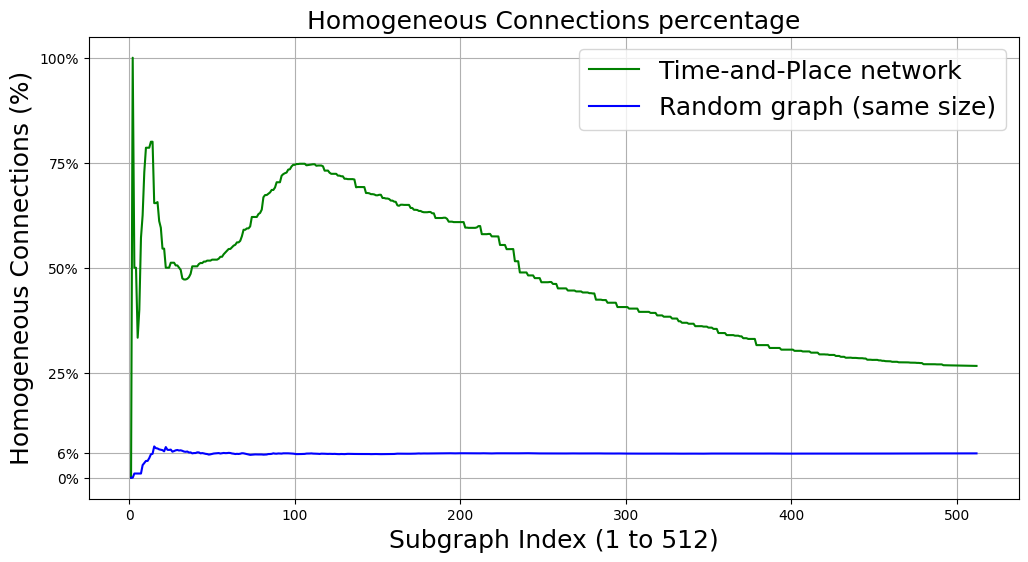

In [610]:
# Visualizing the ratio in a separate graph
plt.figure(figsize=(12, 6))

# Multiply the ratios by 100 to convert them to percentages
plt.plot(range(1, 513), np.array(good_to_total_ratio_discrete) * 100.0, color='green', label='Time-and-Place network')
plt.plot(range(1, connection_ratios_random.shape[0]+1), connection_ratios_random * 100, color='blue', label='Random graph (same size)')

plt.title('Homogeneous Connections percentage', fontsize = 18)
plt.xlabel('Subgraph Index (1 to 512)', fontsize = 18)
plt.ylabel('Homogeneous Connections (%)', fontsize = 18)  # Add a percentage sign to the label
plt.yticks(ticks=[0,6,25,50,75,100], labels=['0%', '6%', '25%', '50%', '75%', '100%'])
plt.legend(fontsize = 18)
plt.grid(True)
plt.show()

### Combined plot:

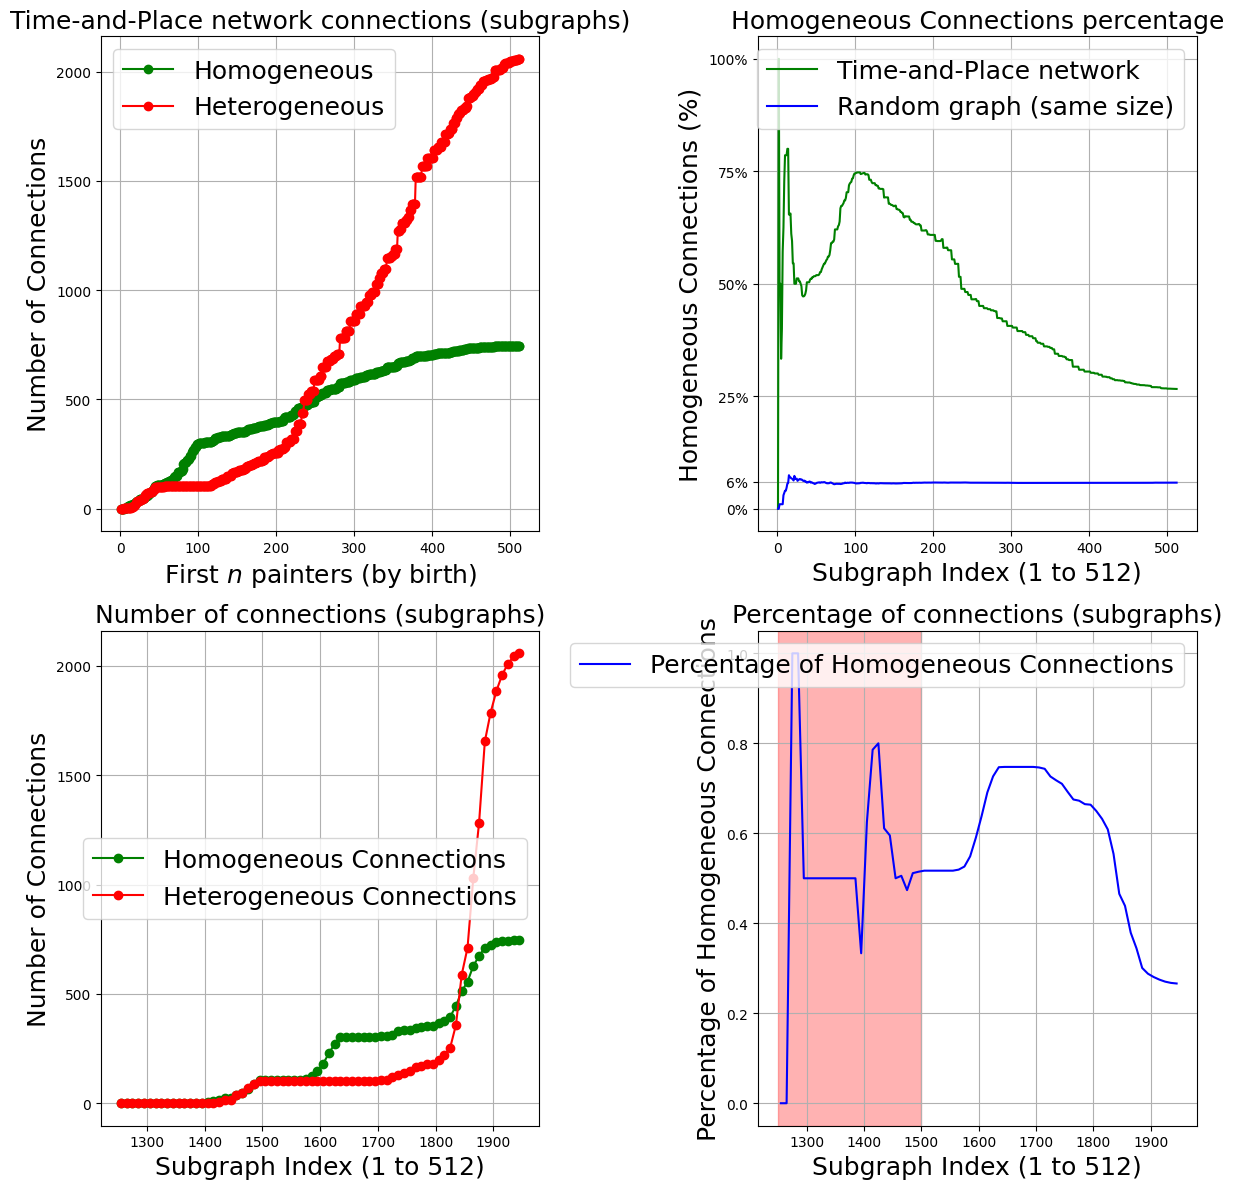

In [615]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot the Time-and-Place network connections (subgraphs)
axes[0, 0].plot(range(1, 513), good_connection_counts_discrete, marker='o', color='green', label='Homogeneous')
axes[0, 0].plot(range(1, 513), bad_connection_counts_discrete, marker='o', color='red', label='Heterogeneous')
axes[0, 0].set_title('Time-and-Place network connections (subgraphs)', fontsize = 18)
axes[0, 0].set_xlabel('First $n$ painters (by birth)', fontsize = 18)
axes[0, 0].set_ylabel('Number of Connections', fontsize = 18)
axes[0, 0].legend(fontsize = 18)
axes[0, 0].grid(True)

# Plot the Homogeneous Connections percentage
axes[0, 1].plot(range(1, 513), np.array(good_to_total_ratio_discrete) * 100.0, color='green', label='Time-and-Place network')
axes[0, 1].plot(range(1, connection_ratios_random.shape[0]+1), connection_ratios_random * 100, color='blue', label='Random graph (same size)')
axes[0, 1].set_title('Homogeneous Connections percentage', fontsize = 18)
axes[0, 1].set_xlabel('Subgraph Index (1 to 512)', fontsize = 18)
axes[0, 1].set_ylabel('Homogeneous Connections (%)', fontsize = 18)  # Add a percentage sign to the label
axes[0, 1].set_yticks(ticks=[0,6,25,50,75,100])
axes[0, 1].set_yticklabels(['0%', '6%', '25%', '50%', '75%', '100%'])
axes[0, 1].legend(fontsize = 18)
axes[0, 1].grid(True)

# Plot the Number of Homogeneous and Heterogeneous Connections in Subgraphs
axes[1, 0].plot(range(min_year, max_year+1, 10), good_connection_counts_yearly, marker='o', color='green', label='Homogeneous Connections')
axes[1, 0].plot(range(min_year, max_year+1, 10), bad_connection_counts_yearly, marker='o', color='red', label='Heterogeneous Connections')
axes[1, 0].set_title('Number of connections (subgraphs)', fontsize = 18)
axes[1, 0].set_xlabel('Subgraph Index (1 to 512)', fontsize = 18)
axes[1, 0].set_ylabel('Number of Connections', fontsize = 18)
axes[1, 0].legend(fontsize = 18)
axes[1, 0].grid(True)

# Plot the Percentage of Homogeneous Connections in Subgraphs
axes[1, 1].plot(range(min_year, max_year+1, 10), good_to_total_ratio, color='blue', label='Percentage of Homogeneous Connections')
axes[1, 1].set_title('Percentage of connections (subgraphs)', fontsize = 18)
axes[1, 1].set_xlabel('Subgraph Index (1 to 512)', fontsize = 18)
axes[1, 1].set_ylabel('Percentage of Homogeneous Connections', fontsize = 18)
axes[1, 1].legend(fontsize = 18)
axes[1, 1].grid(True)
#Add spans
#Add spans
axes[1, 1].axvspan(1250, 1500, color='red', alpha=0.3, label='Initial Fluctuations')


# Display the plots
plt.tight_layout()
plt.show()